K2-18 - one failed guide star, a few failed extractions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/'

In [3]:
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy711010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy711020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo38010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18050_sx1.fits'],
      dtype='<U65')

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy711010_x1d.fits
G140M
754.38135


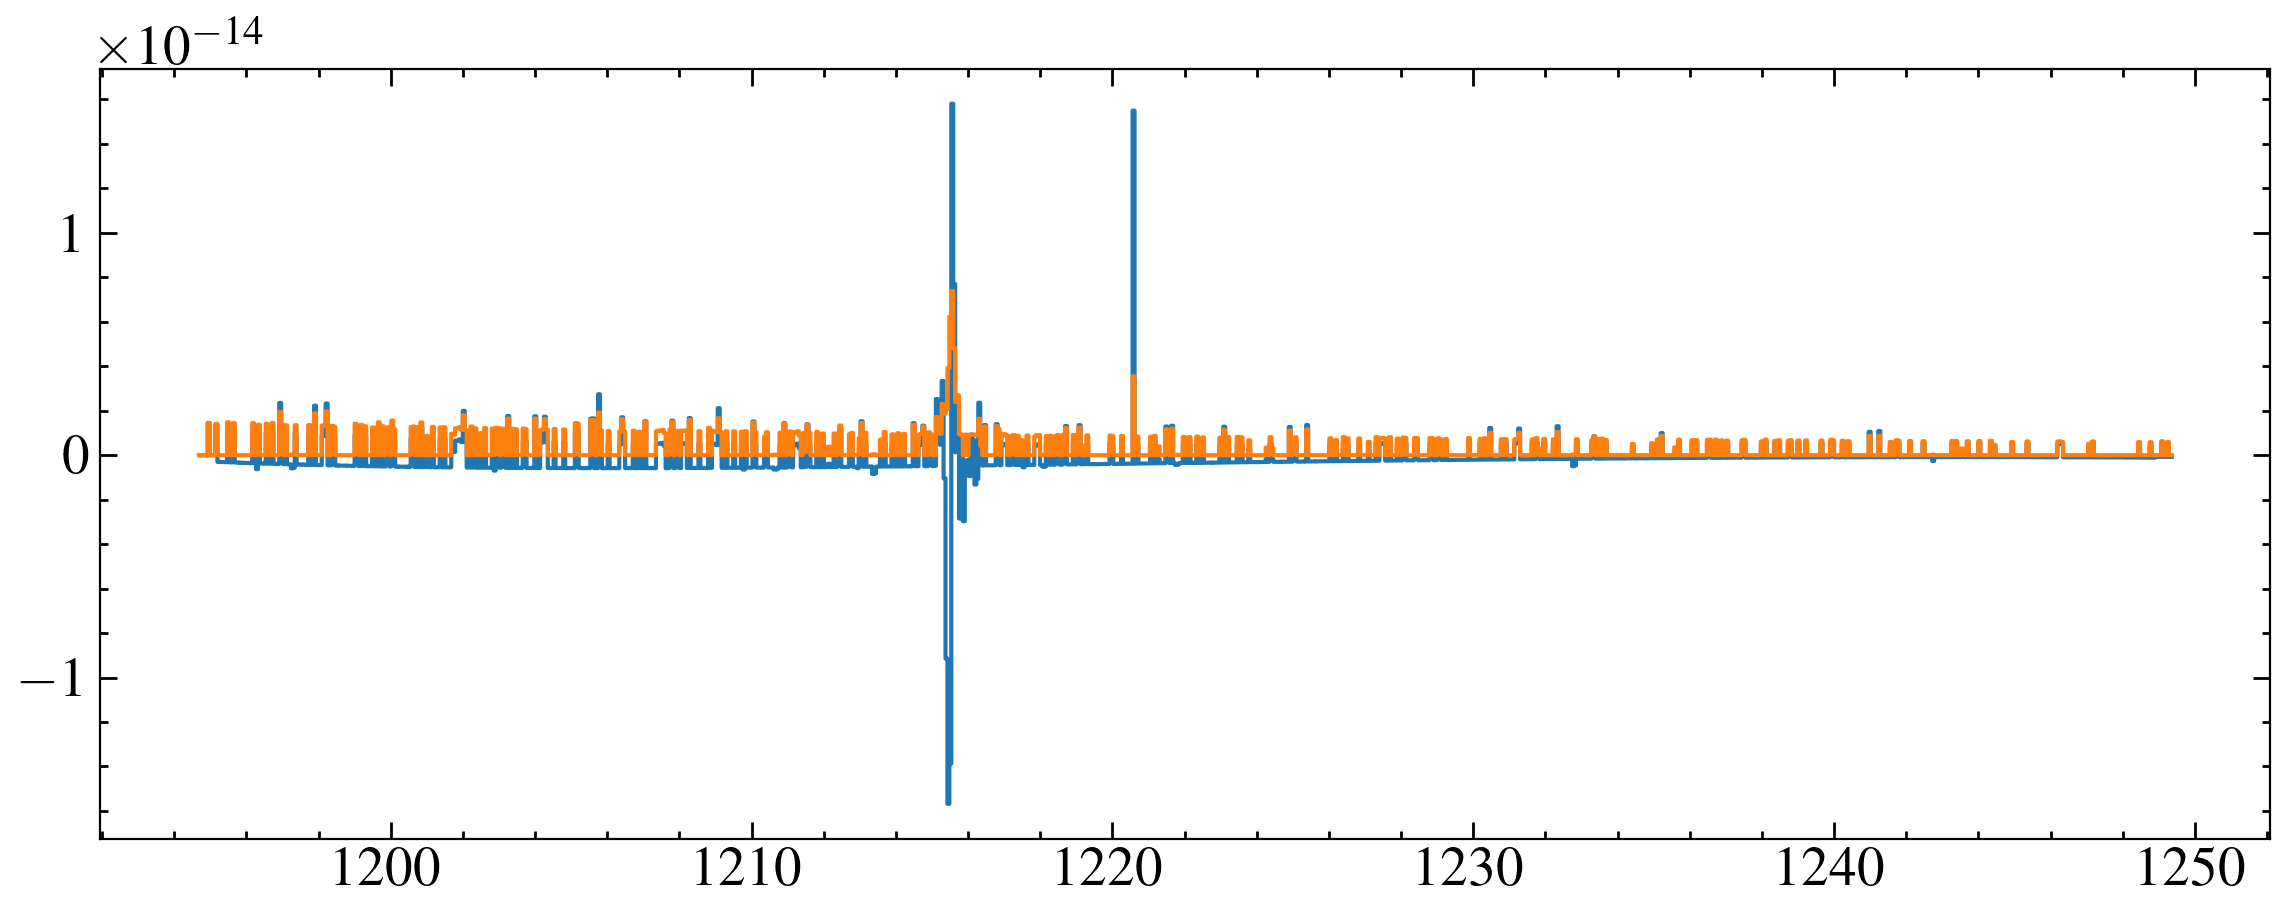

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721010_x1d.fits
G140M
556.3479


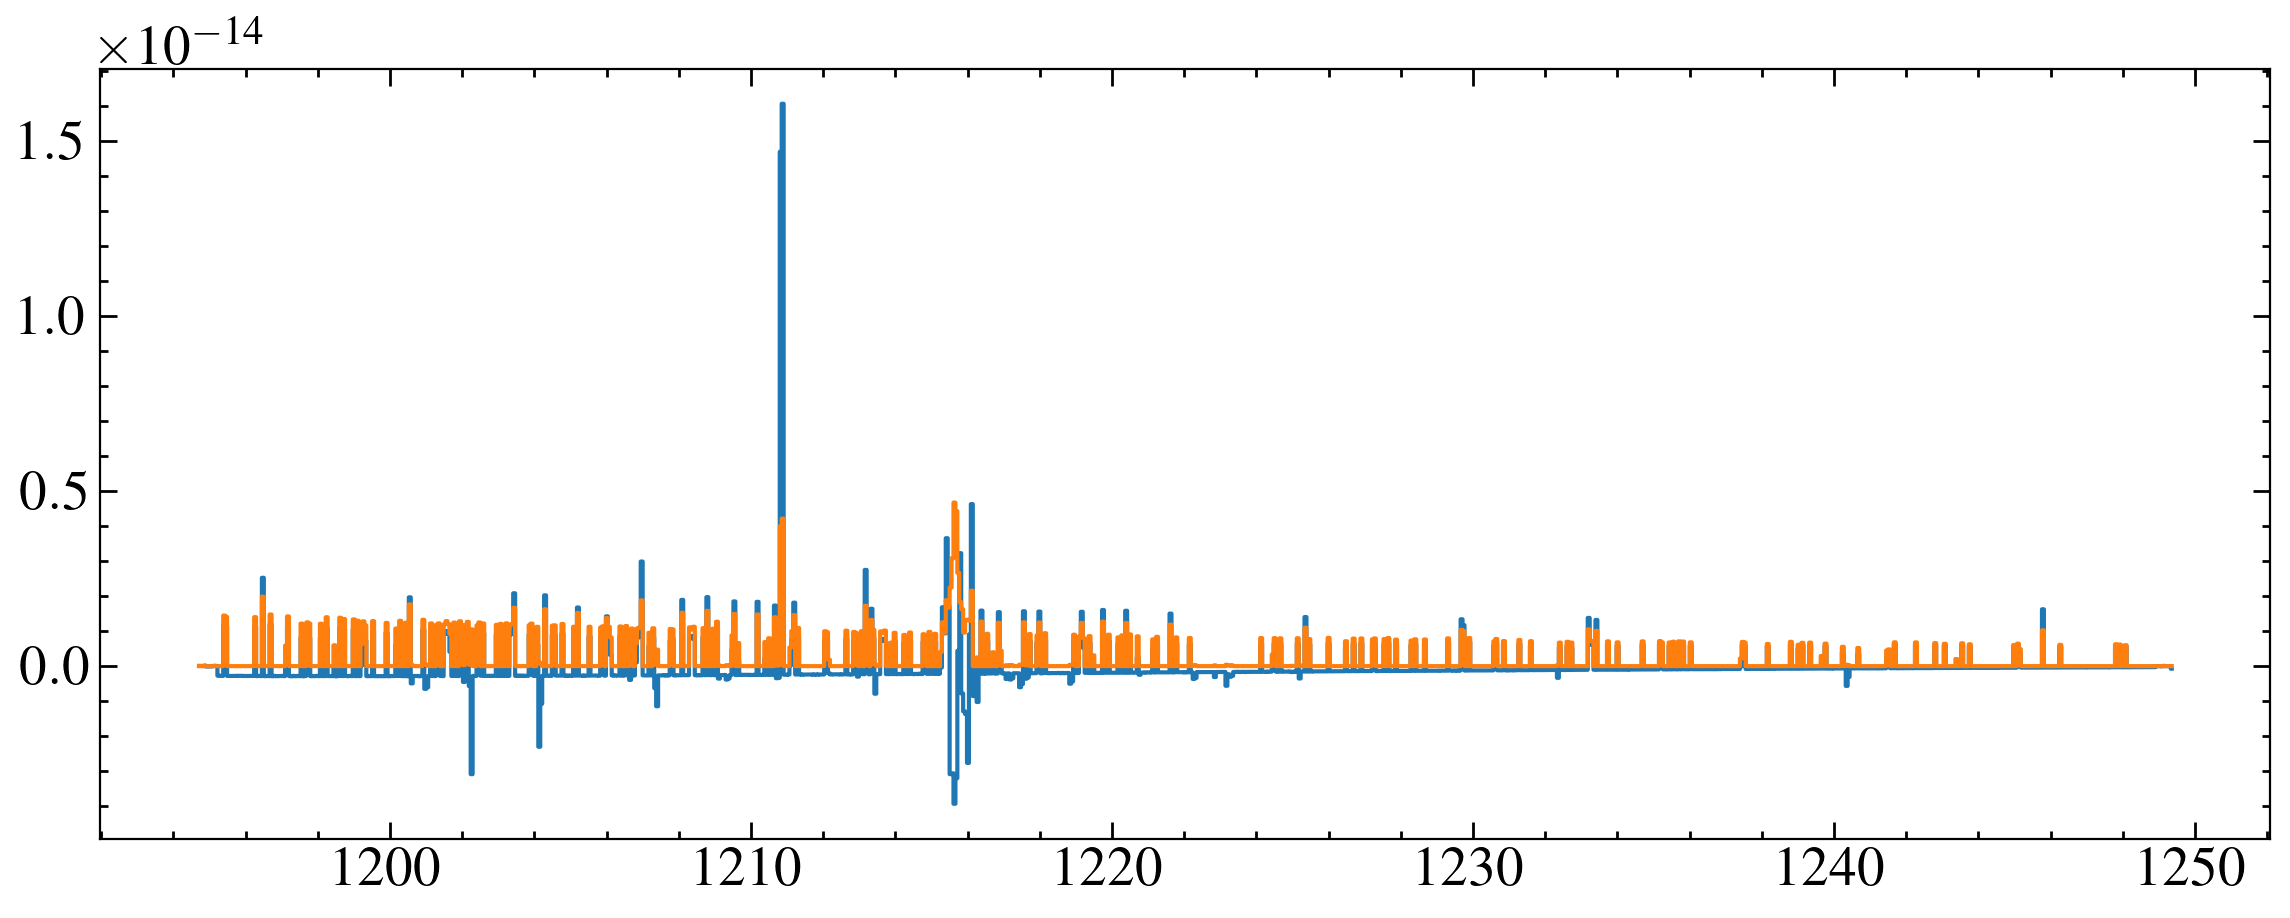

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy711020_x1d.fits
G140M
369.93082


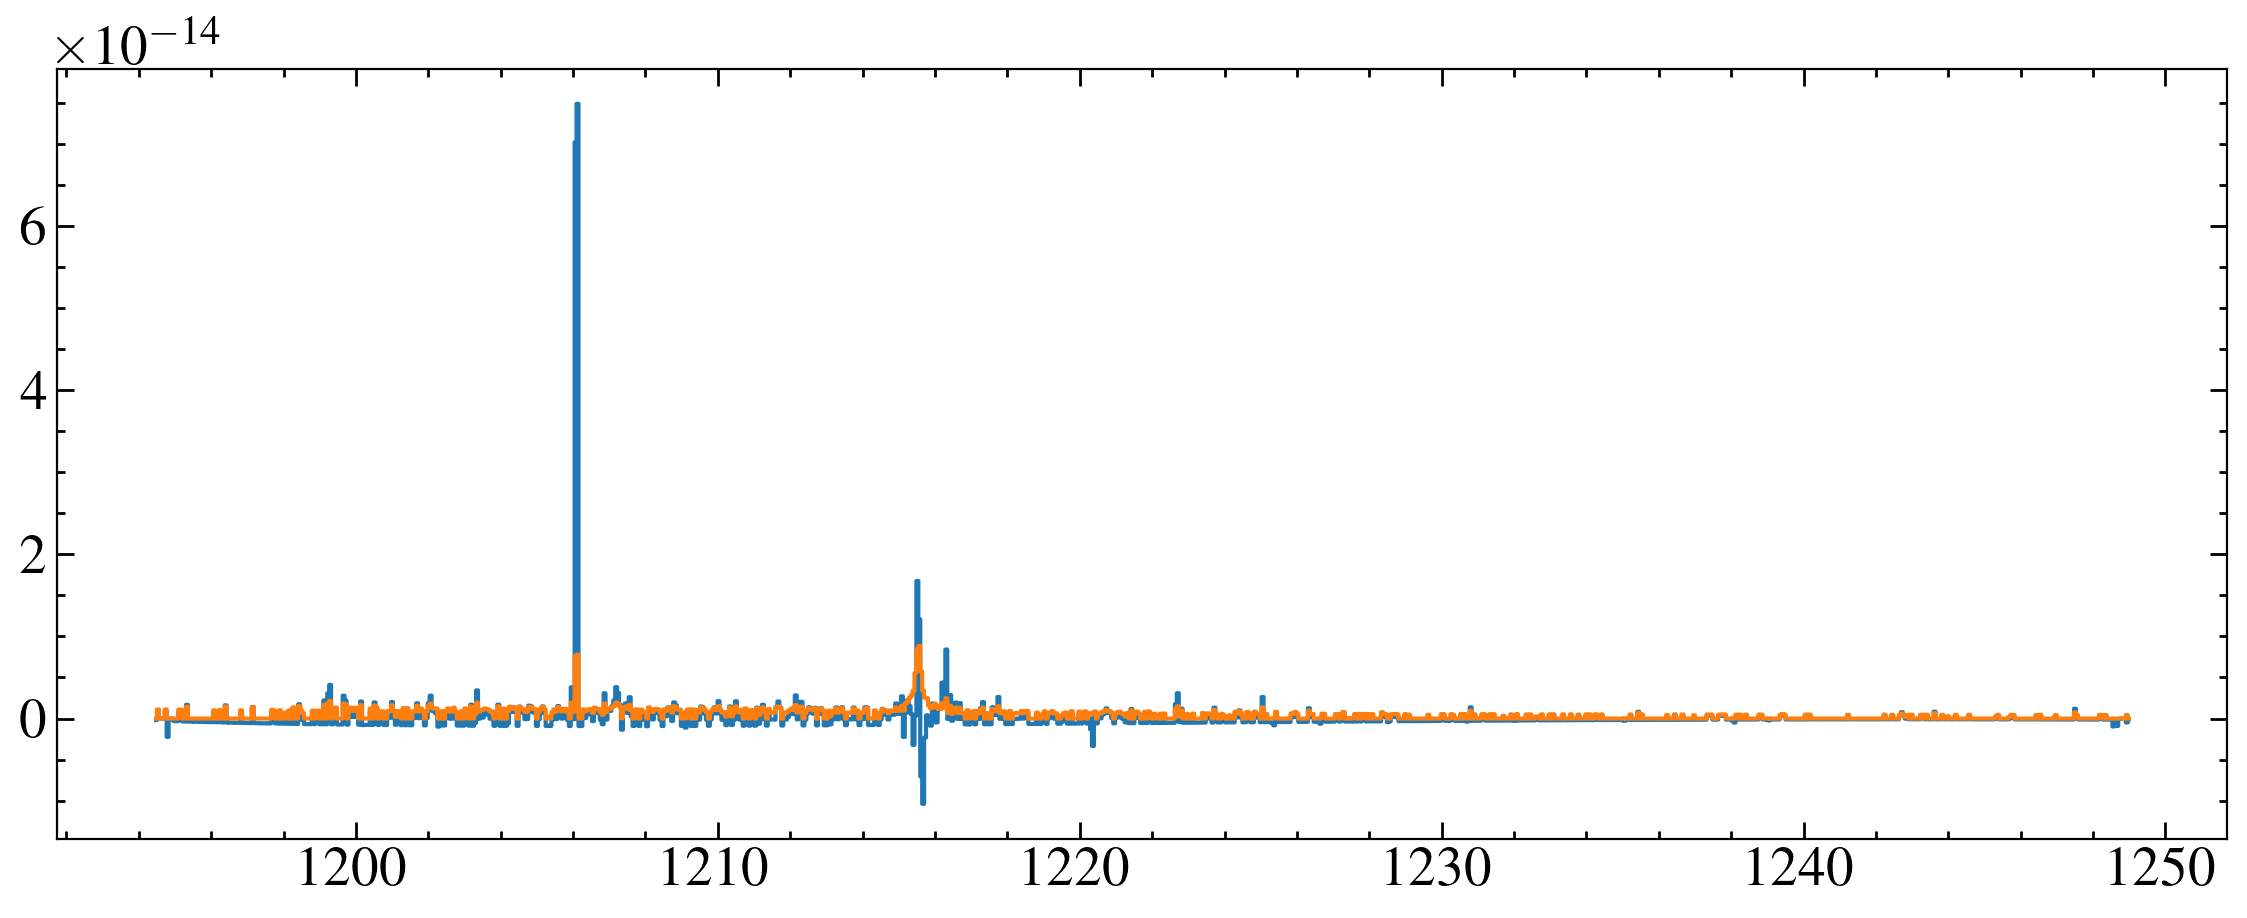

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721020_x1d.fits
G140M
554.9332


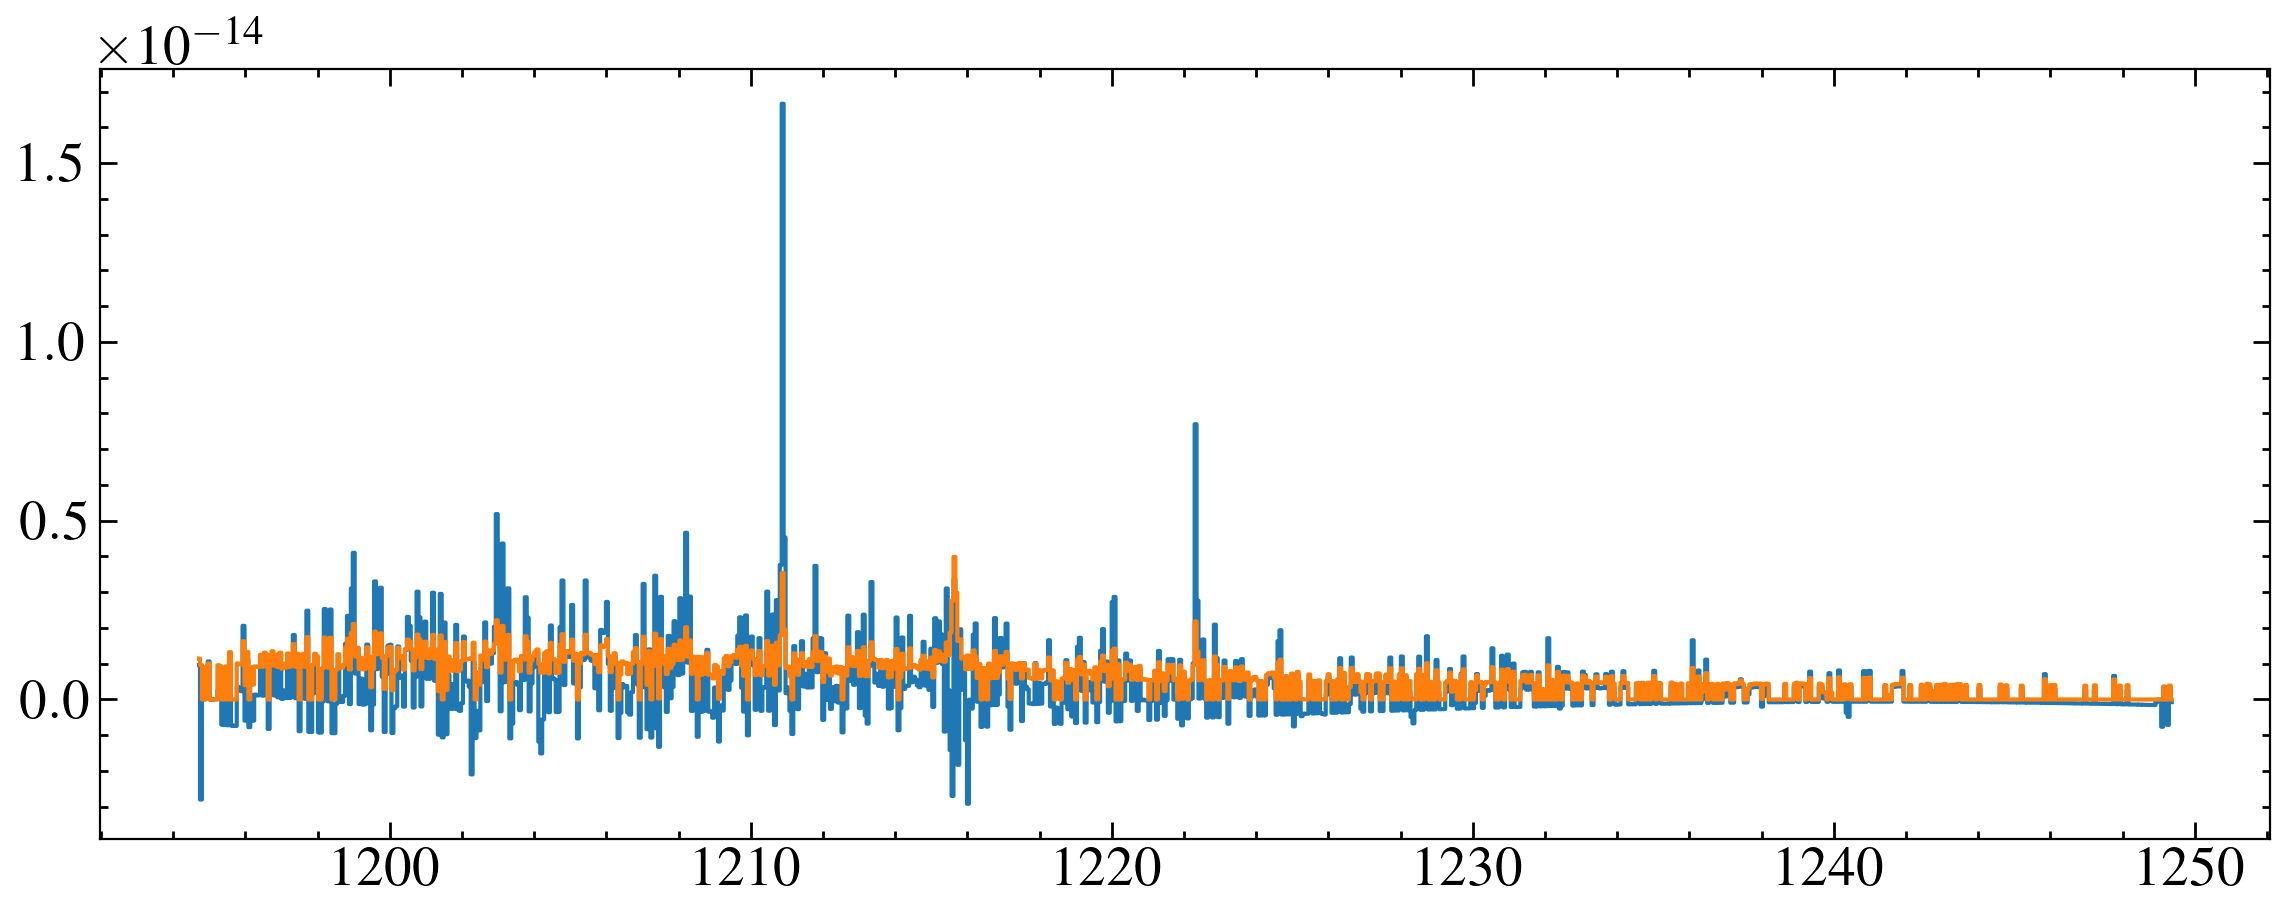

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721030_x1d.fits
G140M
555.46606


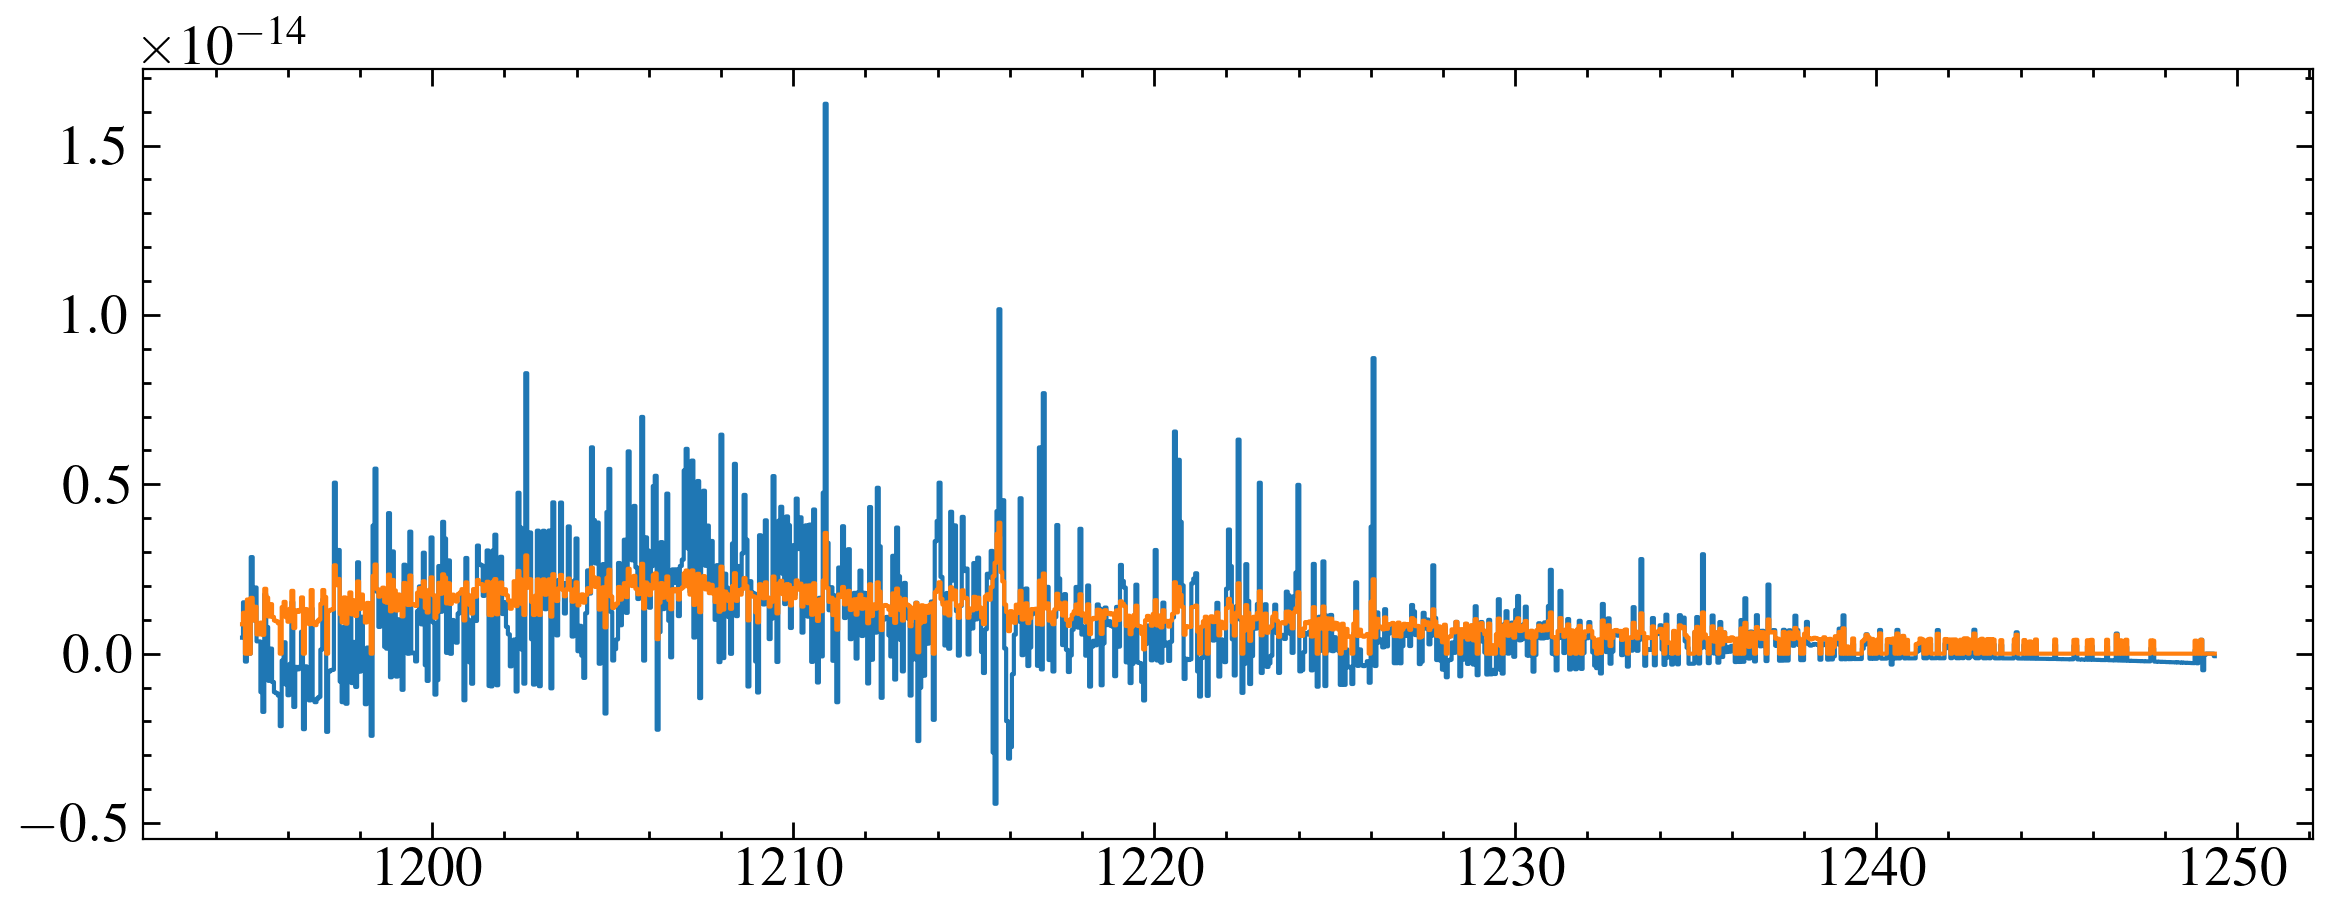

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/ocy721040_x1d.fits
G140M
554.16


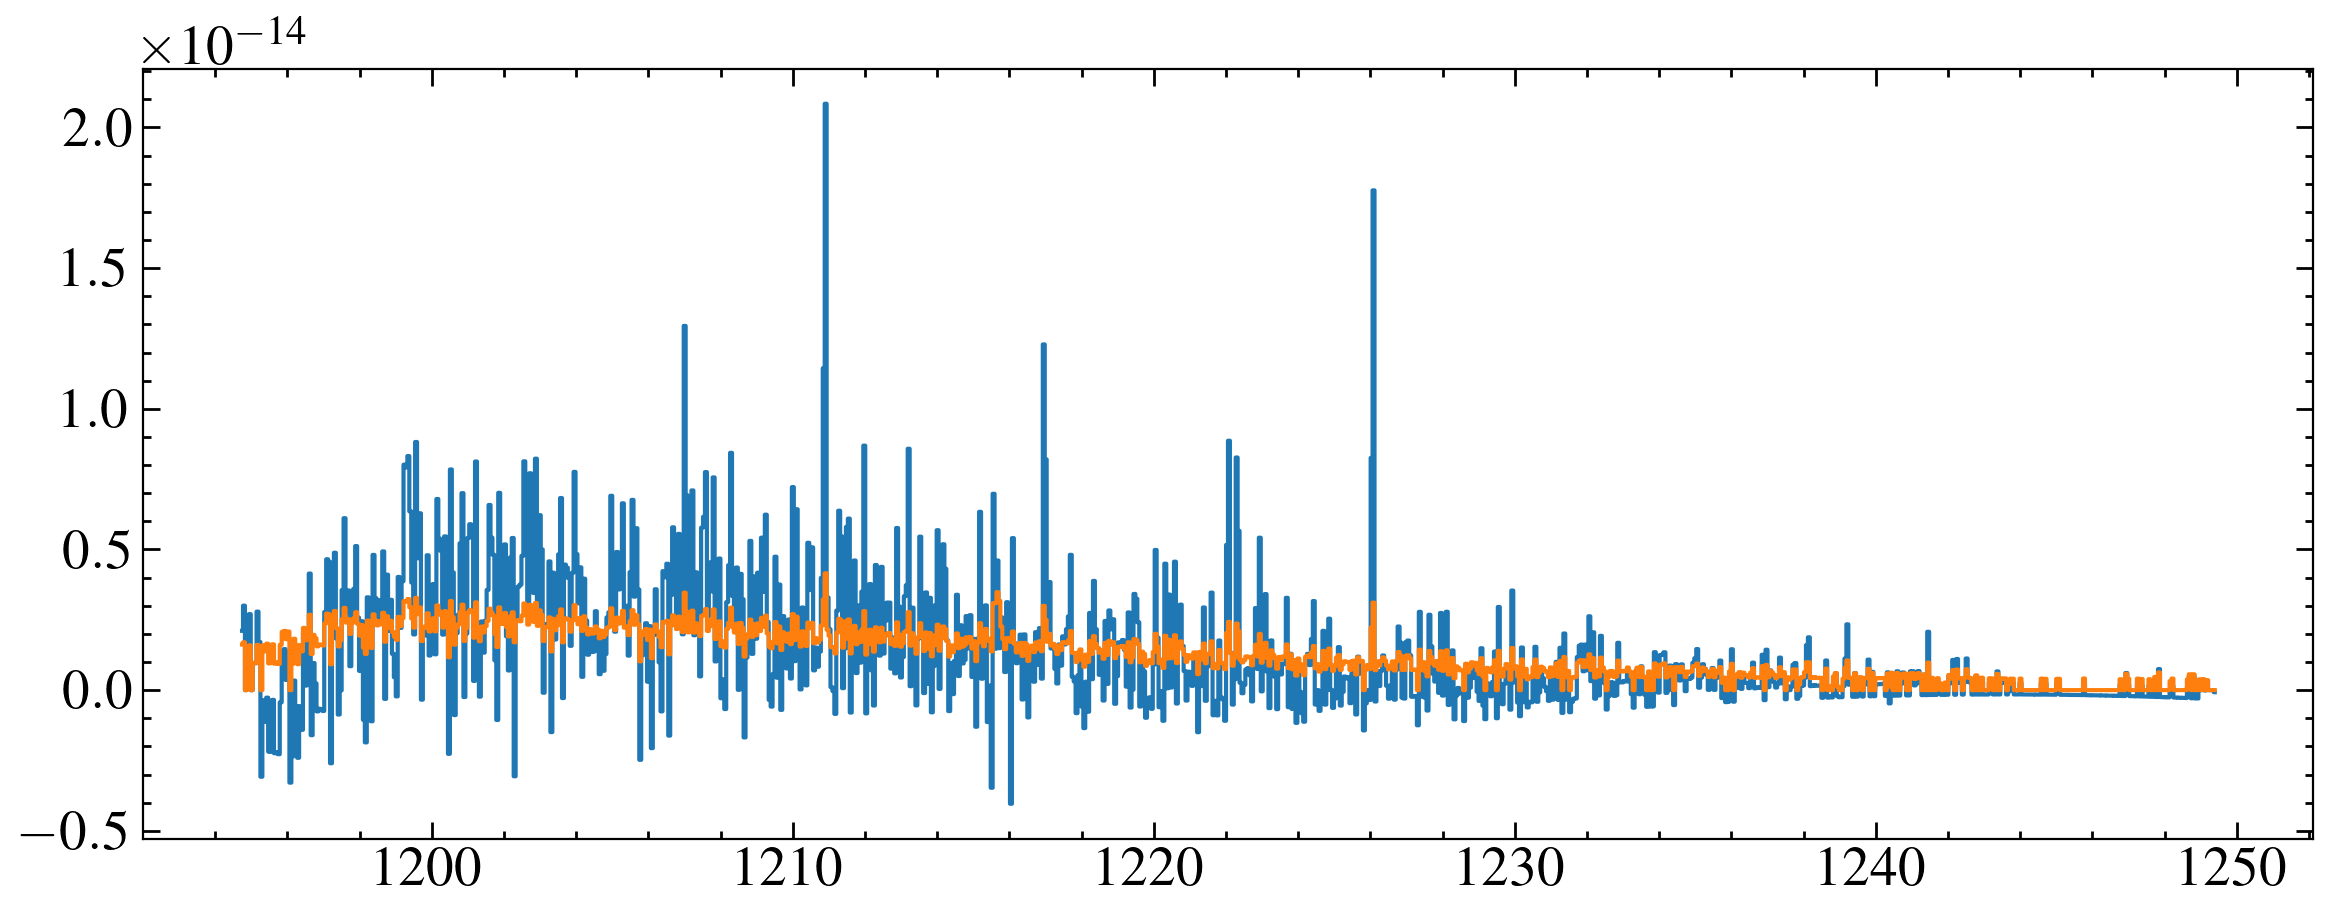

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18020_x1d.fits
G230L
579.05237


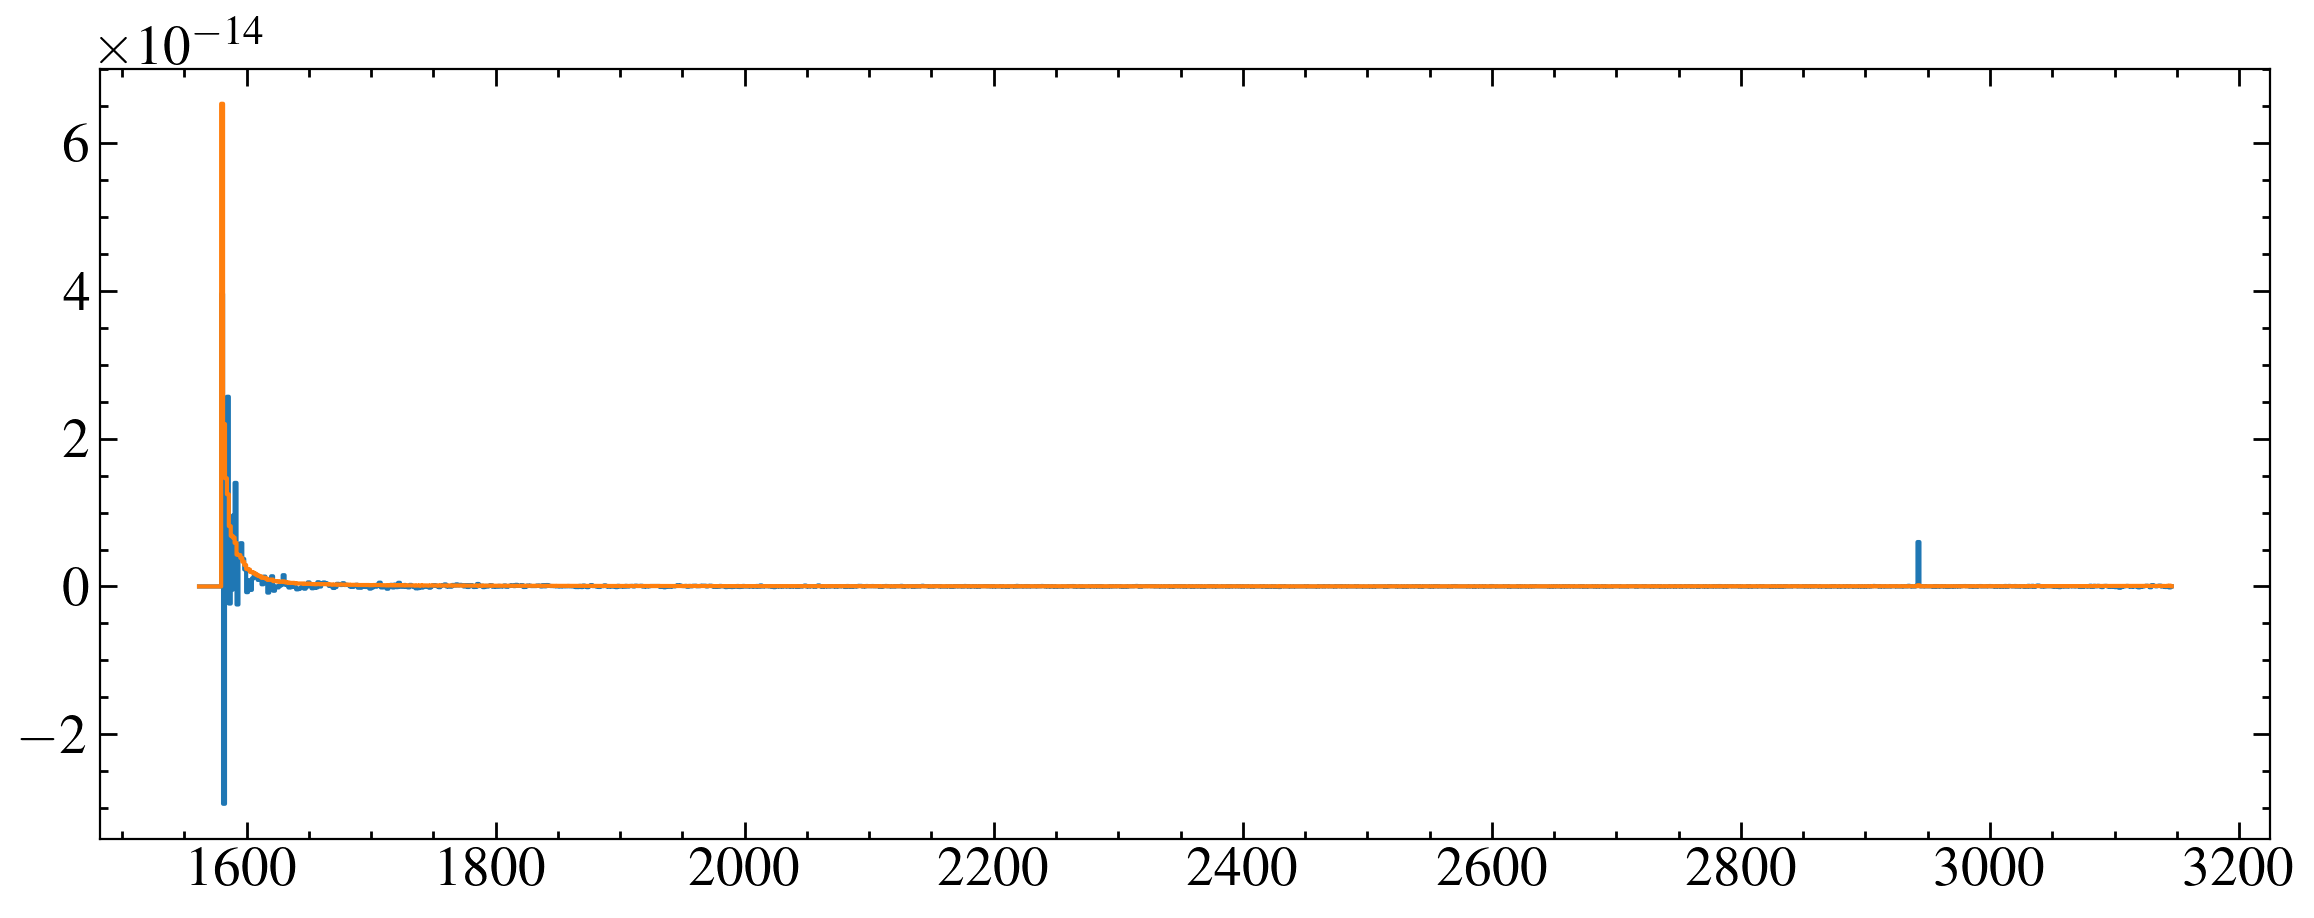

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18030_x1d.fits
G230L
579.08167


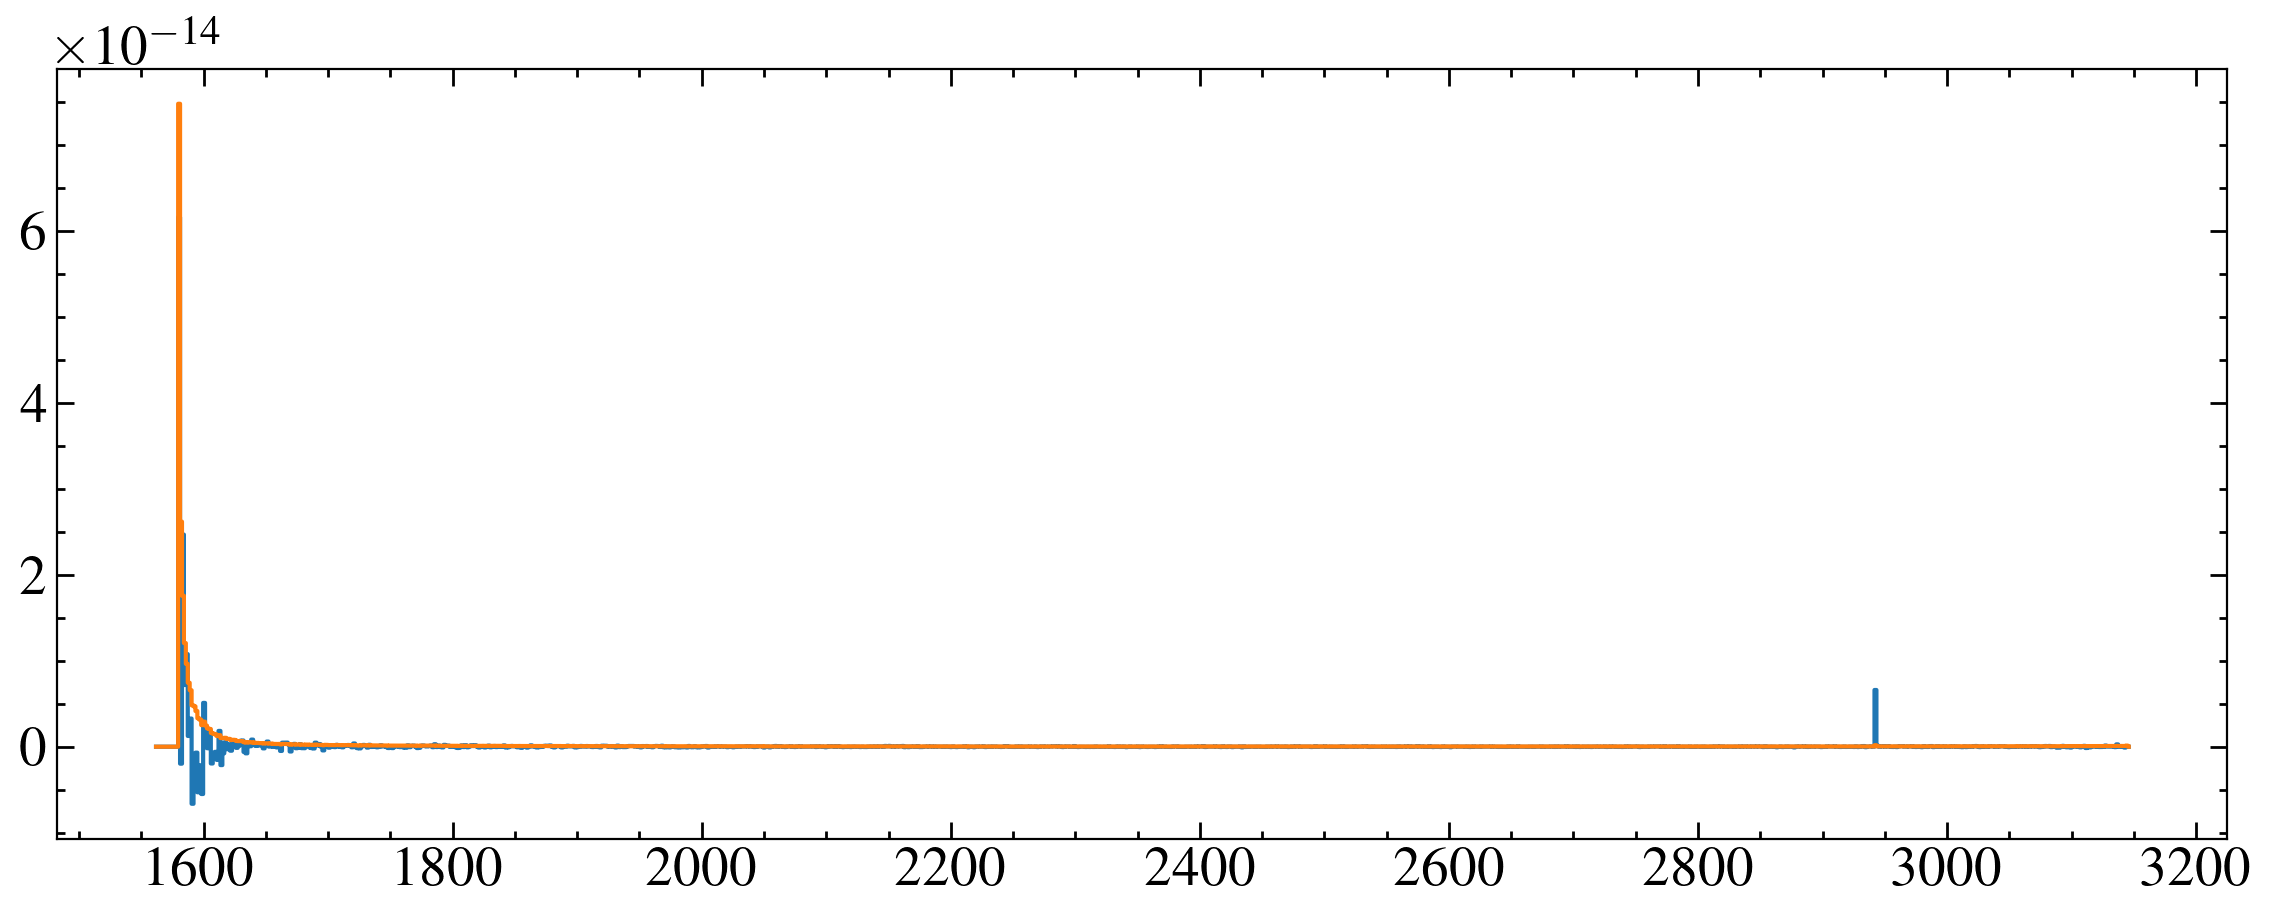

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18040_x1d.fits
G230L
534.12177


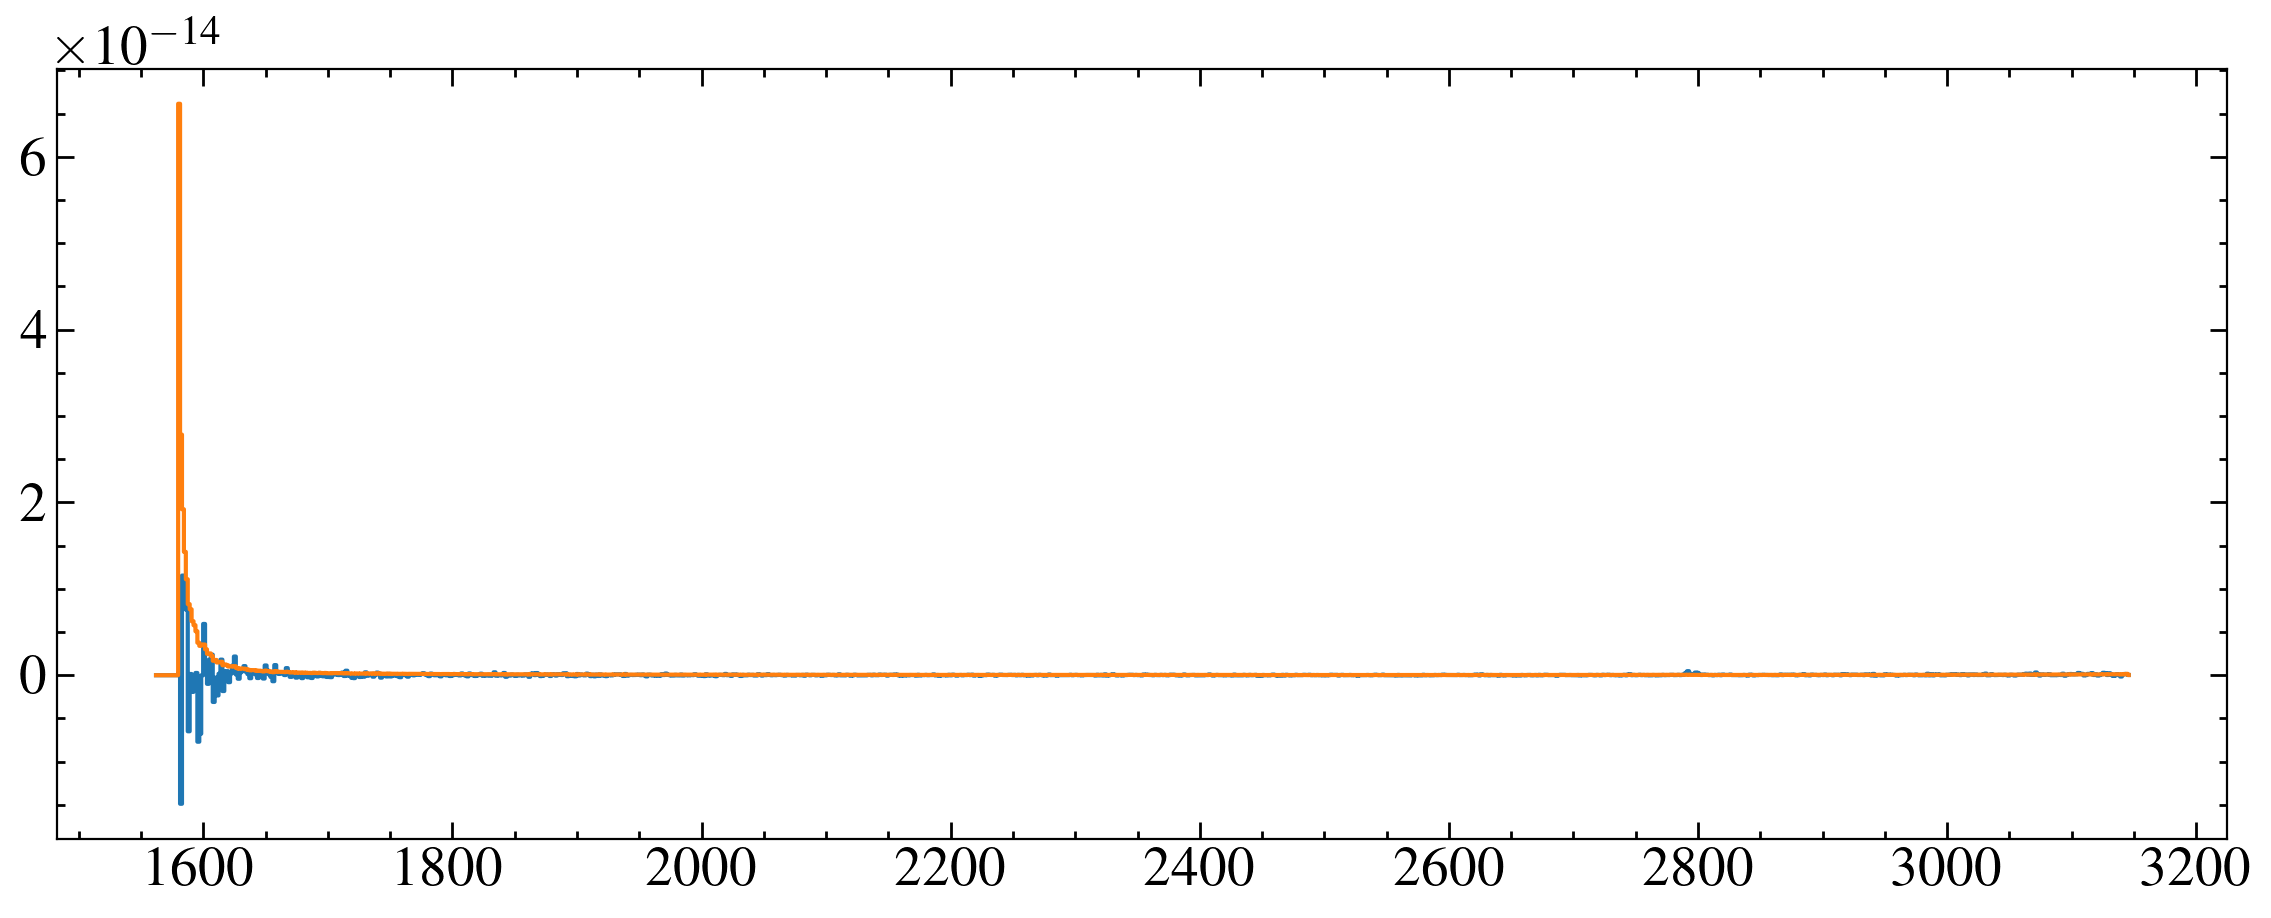

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo38010_x1d.fits
G230L
511.13293


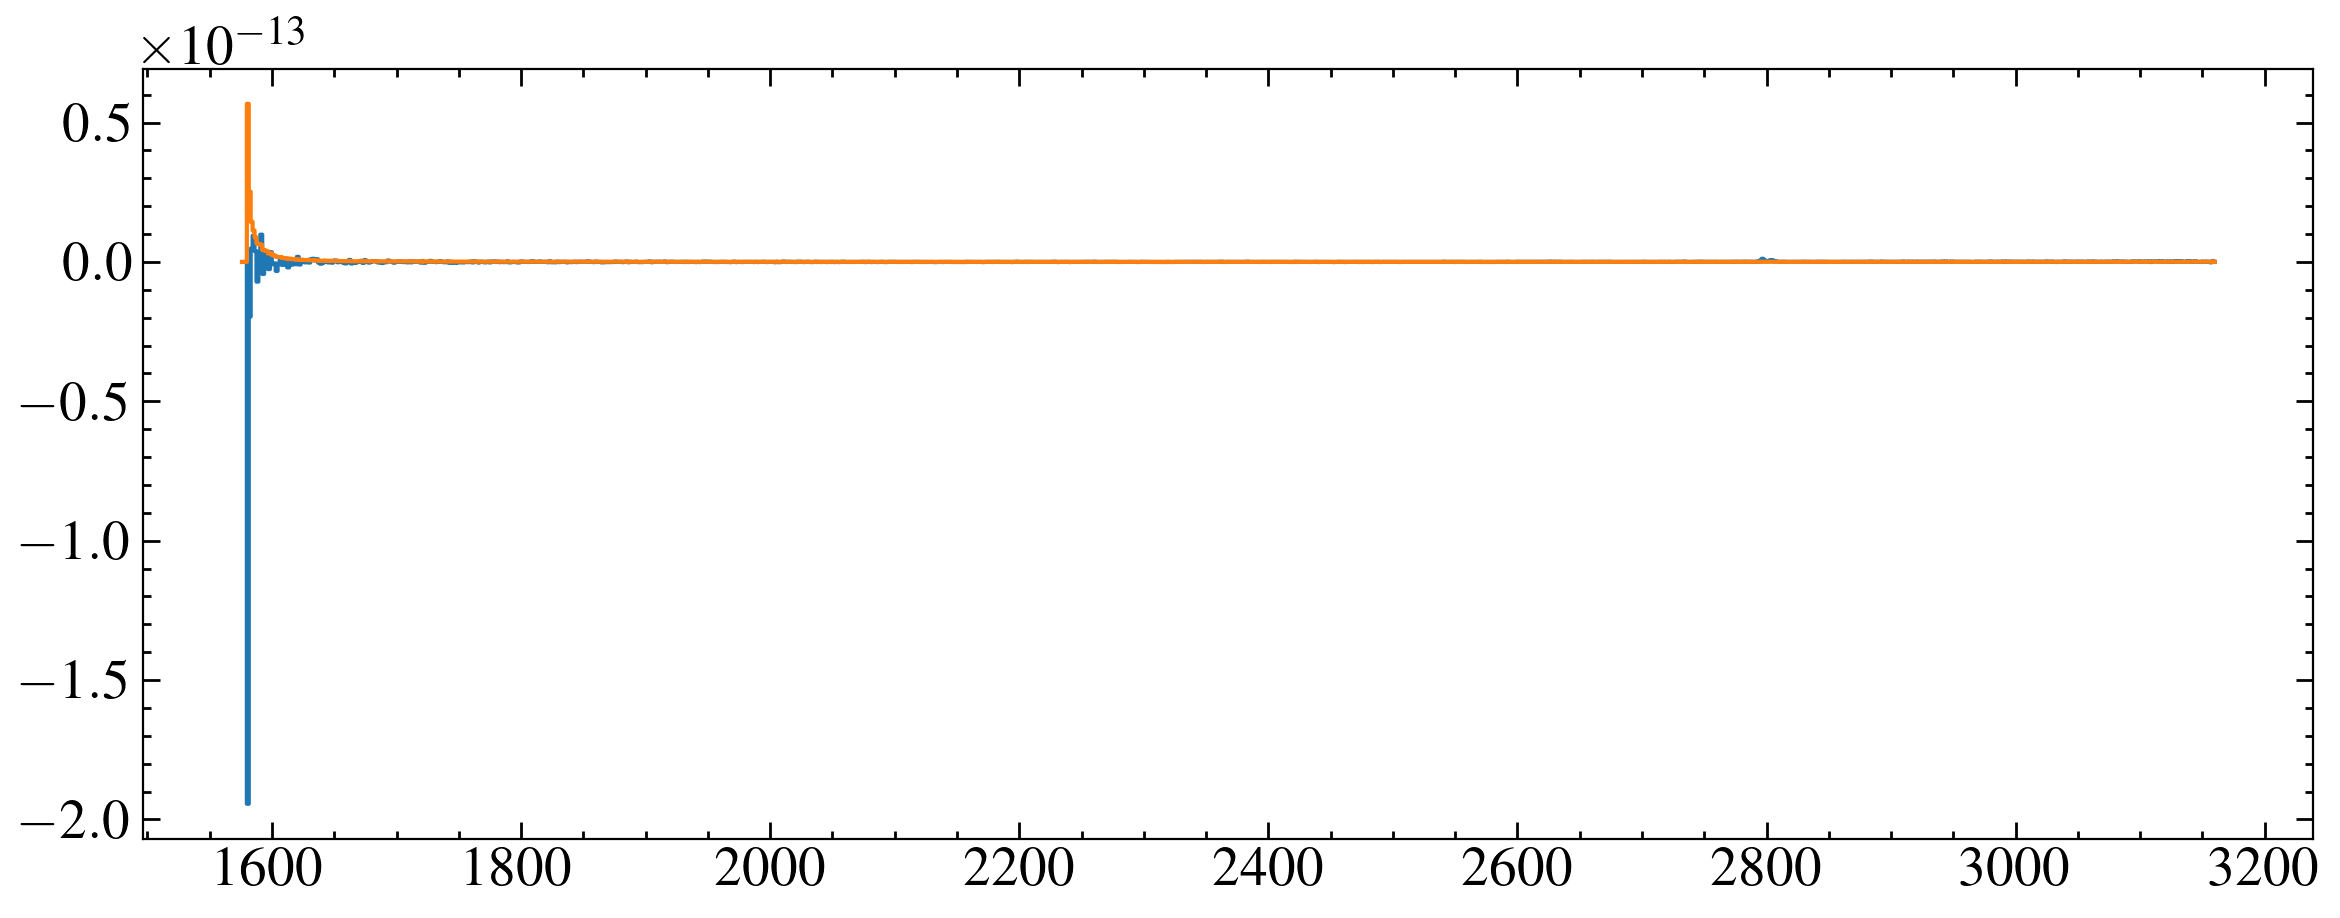

/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18050_sx1.fits
G430L
892.3346


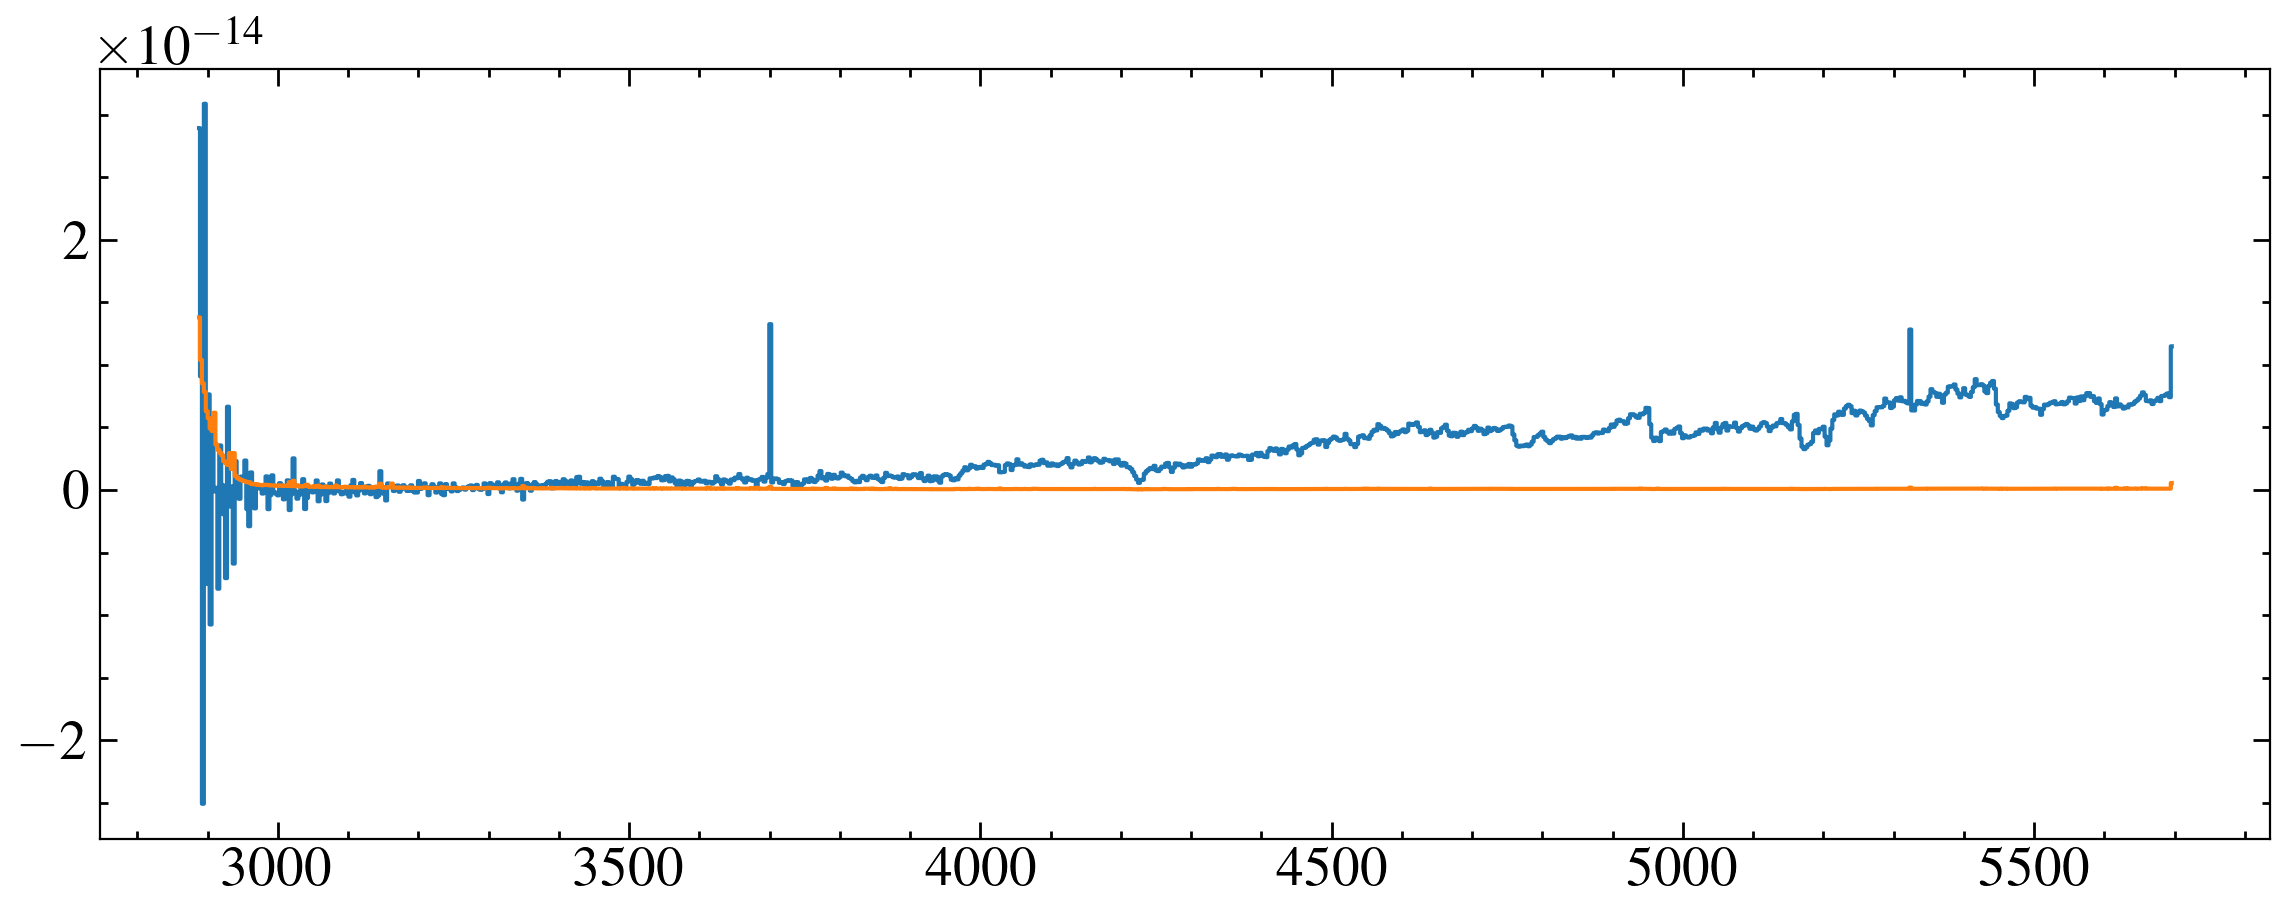

In [4]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [5]:
import stistools
os.environ['oref'] = path 

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [6]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [7]:
xs = [404, 407,400, 400, 403, 402]
ys = [382, 382, 388, 388, 385, 388]
for i, root in  enumerate(['ocy711010', 'ocy711020', 'ocy721010','ocy721020', 'ocy721030', 'ocy721040']):
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    a2center = get_a2center(xs[i],ys[i], tracegrid)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/k2-18/{}_new_x1d.fits'.format(rootname)
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/k2-18/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=5, bk1offst=30, bk2offst=30)

381.13858
390.23047
385.64246
389.28027
389.2686
389.64627


(1210.0, 1220.0)

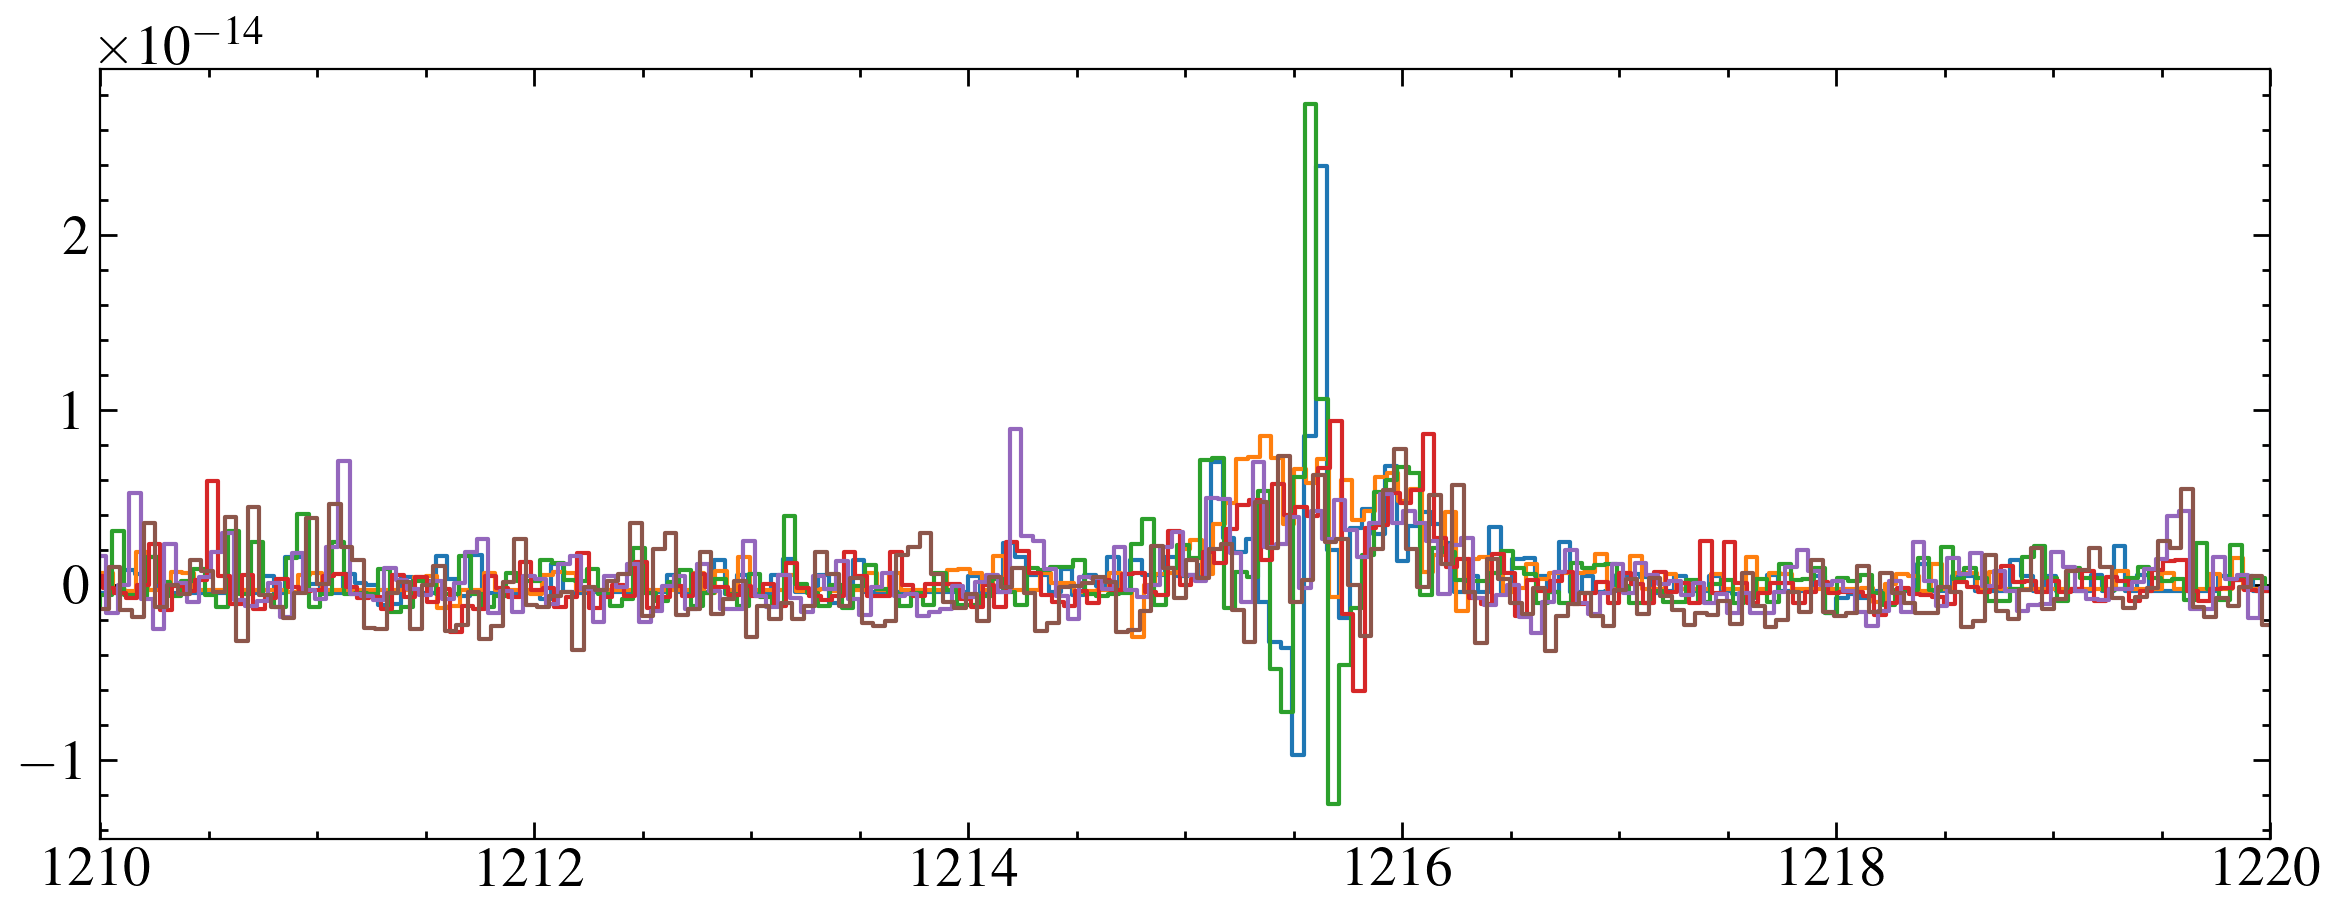

In [8]:

for i, root in  enumerate(['ocy711010', 'ocy721010', 'ocy711020','ocy721020', 'ocy721030', 'ocy721040']):
        data = fits.getdata('reextractions/k2-18/{}_new_x1d.fits'.format(root), 1)[0]
        print(data['A2Center'])
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        # mask = w > 1700
        # w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid')
        # plt.step(w, e, where='mid')
        # plt.show()
plt.xlim(1210, 1220)

That'll do, it's not like we need it.

In [9]:
# for root in  ['oeoo18020', 'oeoo18030']:
#         data = fits.getdata('reextractions/k2-18/{}_new_x1d.fits'.format(root), 1)[0]
#         print(data['A2Center'])
#         w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#         w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#         mask = w > 1700
#         w, f, e = w[mask], f[mask], e[mask]
#         plt.step(w, f, where='mid')
#         plt.step(w, e, where='mid')
#         plt.show()


all G140Ms need reextraction

In [10]:
# for root in  ['oeoo18020', 'oeoo18030']:

#     raw = '{}/{}_flt.fits'.format(path, root)
#     rootname = fits.getheader(raw)['ROOTNAME'] 
#     outname = 'reextractions/k2-18/{}_new_x1d.fits'.format(rootname)
#     stistools.x1d.x1d(raw, output = outname, trailer='reextractions/k2-18/{}_new.trl'.format(rootname), a2center=534, maxsrch=5)

In [11]:
# for x in x1ds:
#     print(x)
#     print(fits.getheader(x, 0)['OPT_ELEM'])
#     data = fits.getdata(x, 1)[0]
#     print(data['A2Center'])
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     print(len(w), len(f), len(e))
#     print(len(e[np.isnan(e)==True]))
#     print(len(e[e< 0]))
#     mask = w > 1160 
#     w, f, e = w[mask], f[mask], e[mask]
#     print(len(w), len(f), len(e))
#     plt.step(w, f, where='mid')
#     # plt.step(w, e, where='mid')
#     # plt.show()
#     plt.yscale('log')
#     # plt.xscale('log')
#     # plt.xlim(2800, 3200)

In [12]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

In [13]:
# x1ds

In [17]:
x1ds = glob.glob('/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/*.fits')
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/oeoo18020_new_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/oeoo18030_new_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/oeoo18040_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/oeoo18050_sx1.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/oeoo38010_x1d.fits']

In [18]:
# gratings = []
# for x in x1ds:
#     gratings.append(fits.getheader(x, 0)['OPT_ELEM'])
# print(gratings)
    

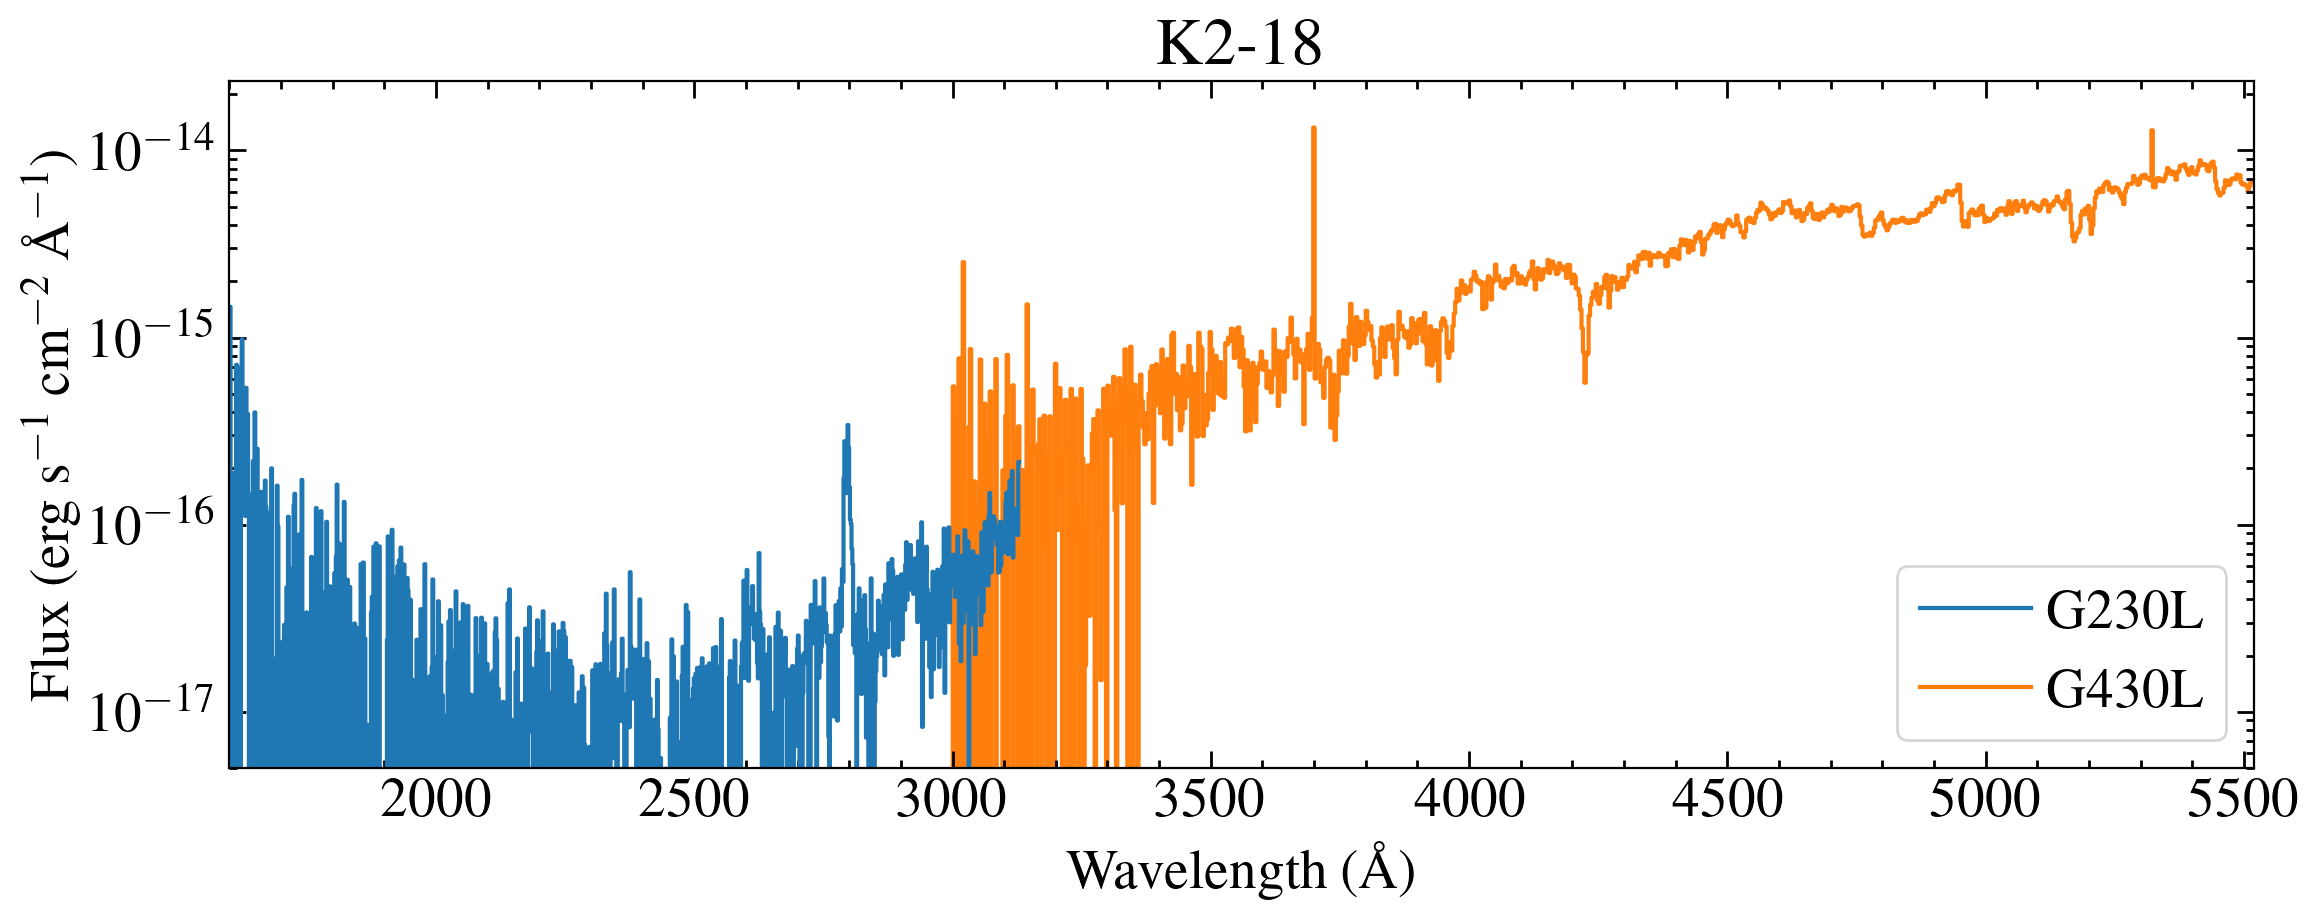

In [19]:
plt.figure(figsize=(12, 5))

f_nuv = []
e_nuv = []

n=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1600) & (w <3130)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    # if grating == 'G230L':
    #     mask = (w > 1700) & (w <3130)
    #     w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]
        
f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)

# plt.step(w_fuv, f_fuv, label='G140L')
plt.step(w_nuv, f_nuv, label='G230L')
plt.step(w_opt, f_opt, label='G430L', zorder=-1)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(5e-18)
plt.xlim(1600, 5520)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('K2-18')
plt.tight_layout()
plt.savefig('plots/k2-18_ql.pdf')
plt.savefig('plots/k2-18_ql.png', facecolor='w')

In [20]:
# fig, axes = plt.subplots(figsize=(14, 18))

# for i, x in enumerate(x1ds):
#     plt.subplot(5,1,i+1)
#     # print(x)
#     # print(fits.getheader(x, 0)['OPT_ELEM'])
#     data = fits.getdata(x, 1)[0]
#     hdr = fits.getheader(x, 0)
#     grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
#     # print(data['A2Center'])
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating == 'G140L':
#         mask = (w > 1160)
#         plt.ylim(-1e-16, 1.1e-15)
#     if grating == 'G230L':
#         mask = (w > 1650) & (w <3130)
#     if grating == 'G430L':
#         mask = (w > 3000) & (w <5520)
#         plt.ylim(-1e-15, 1.1e-14)
#     w, f, e = w[mask], f[mask], e[mask]
#     plt.step(w, f, where='mid', label='FLUX')
#     plt.step(w, e, where='mid', alpha=0.5, label='ERROR')
#     # if i < len(x1ds)-1: 
#         # plt.xticks(visible=False)
#     if i == 0:
#         plt.legend(frameon=True, loc=1)
#     plt.annotate('{} ({})'.format(root, grating), (0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
        
# fig.add_subplot(111, frame_on=False)
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=12)
# plt.xlabel('Wavelength (\AA)')
# plt.tight_layout()
# # plt.subplots_adjust(hspace=0.1)

# plt.savefig('plots/k2-18_all_stis.pdf')
# plt.savefig('plots/k2-18_all_stis.png', facecolor='w')
#     # plt.show()
    

In [21]:
# for x in x1ds:
#     data = fits.getdata(x, 1)[0]
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     grating = fits.getheader(x, 0)['OPT_ELEM']
#     if grating == 'G230L':
#         mask = (w > 1700) & (w <3130)
#         w, f, e = w[mask], f[mask], e[mask]
#         # plt.step(w, f, where='mid', label='FLUX')
#         plt.errorbar(w, f, yerr=e, drawstyle='steps-mid', errorevery=5)
# plt.xlim(2770, 2830)
# plt.ylim(-0.5e-16, 6e-16)

In [22]:
import importlib
import prepare_stis
importlib.reload(prepare_stis)

<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


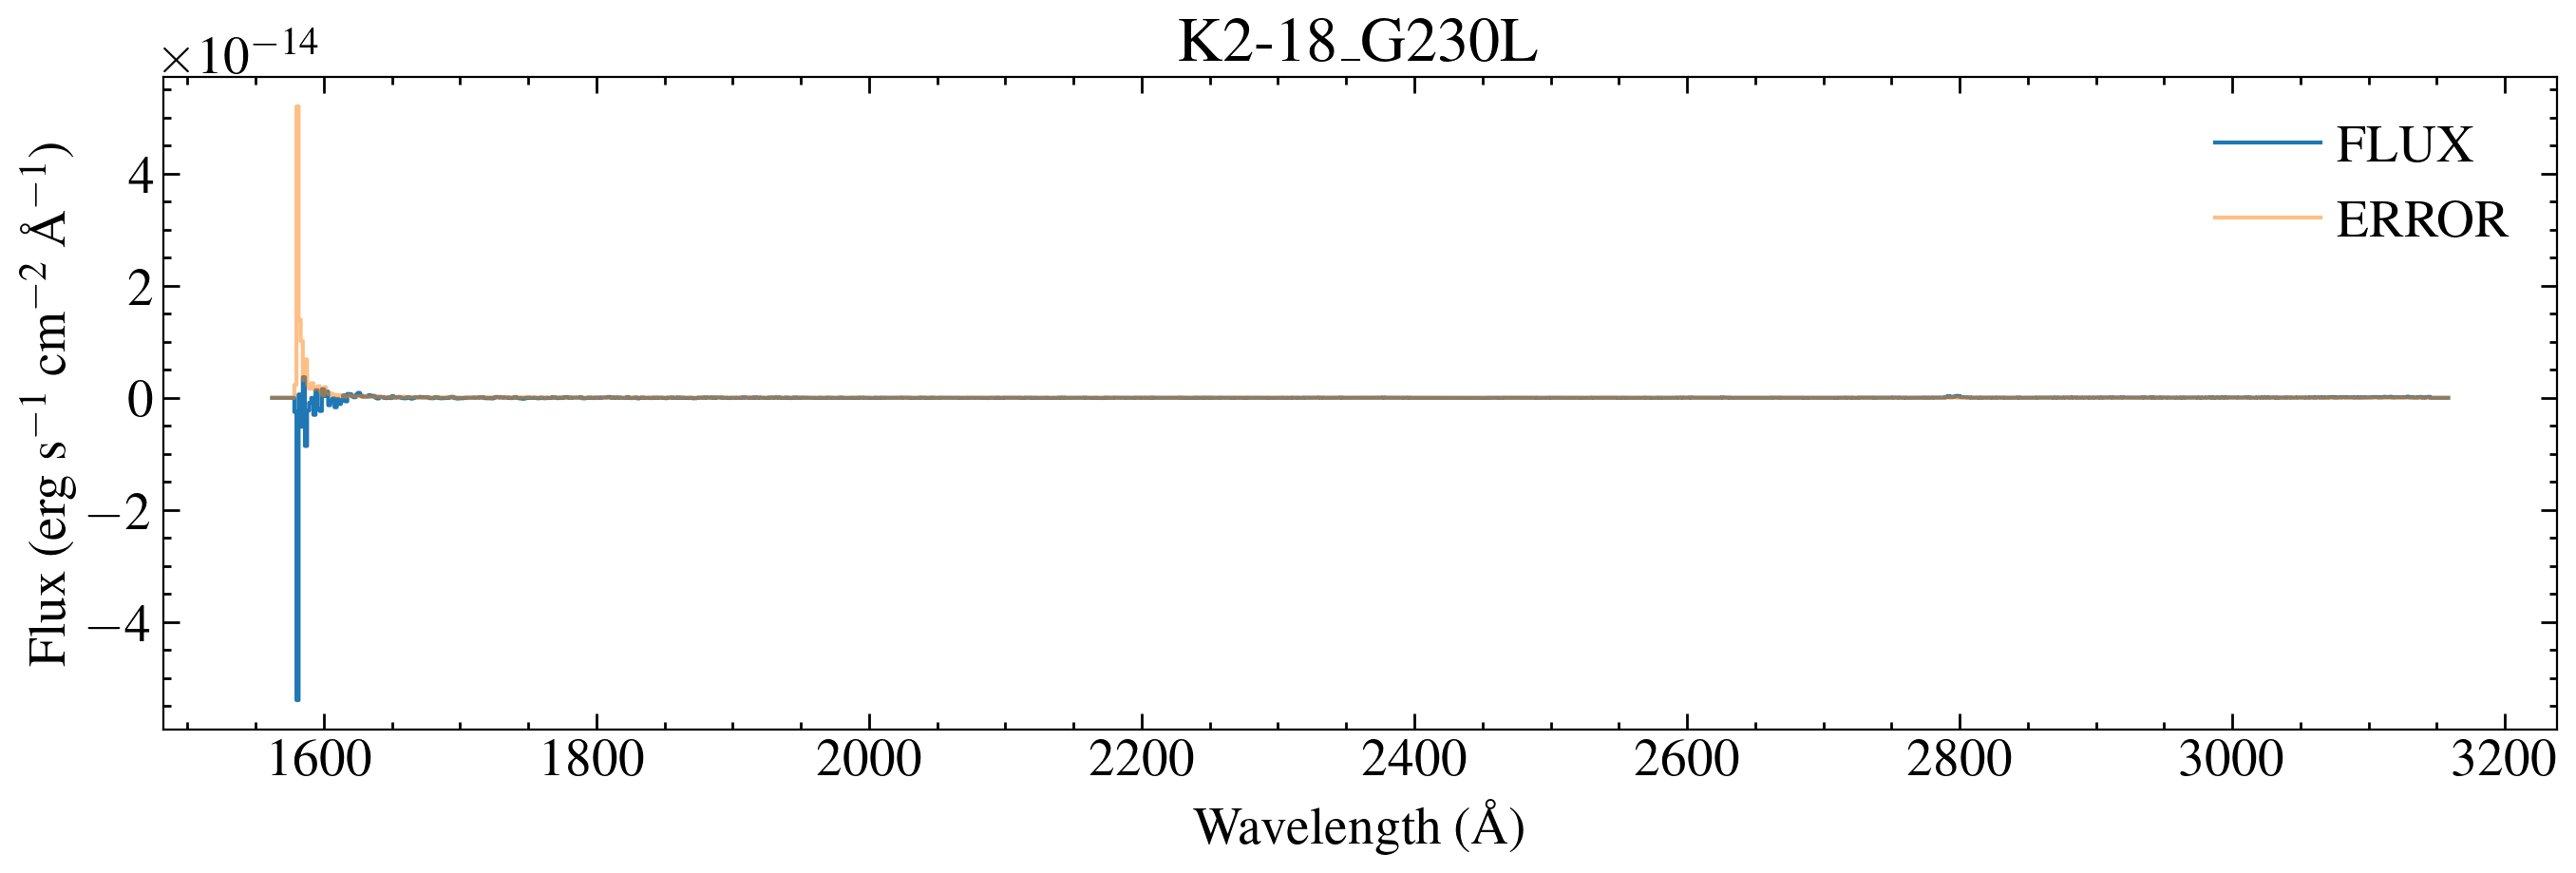

Spectrum saved as hlsp_muscles_hst_stis_k2-18_g230l_v1_component-spec.fits


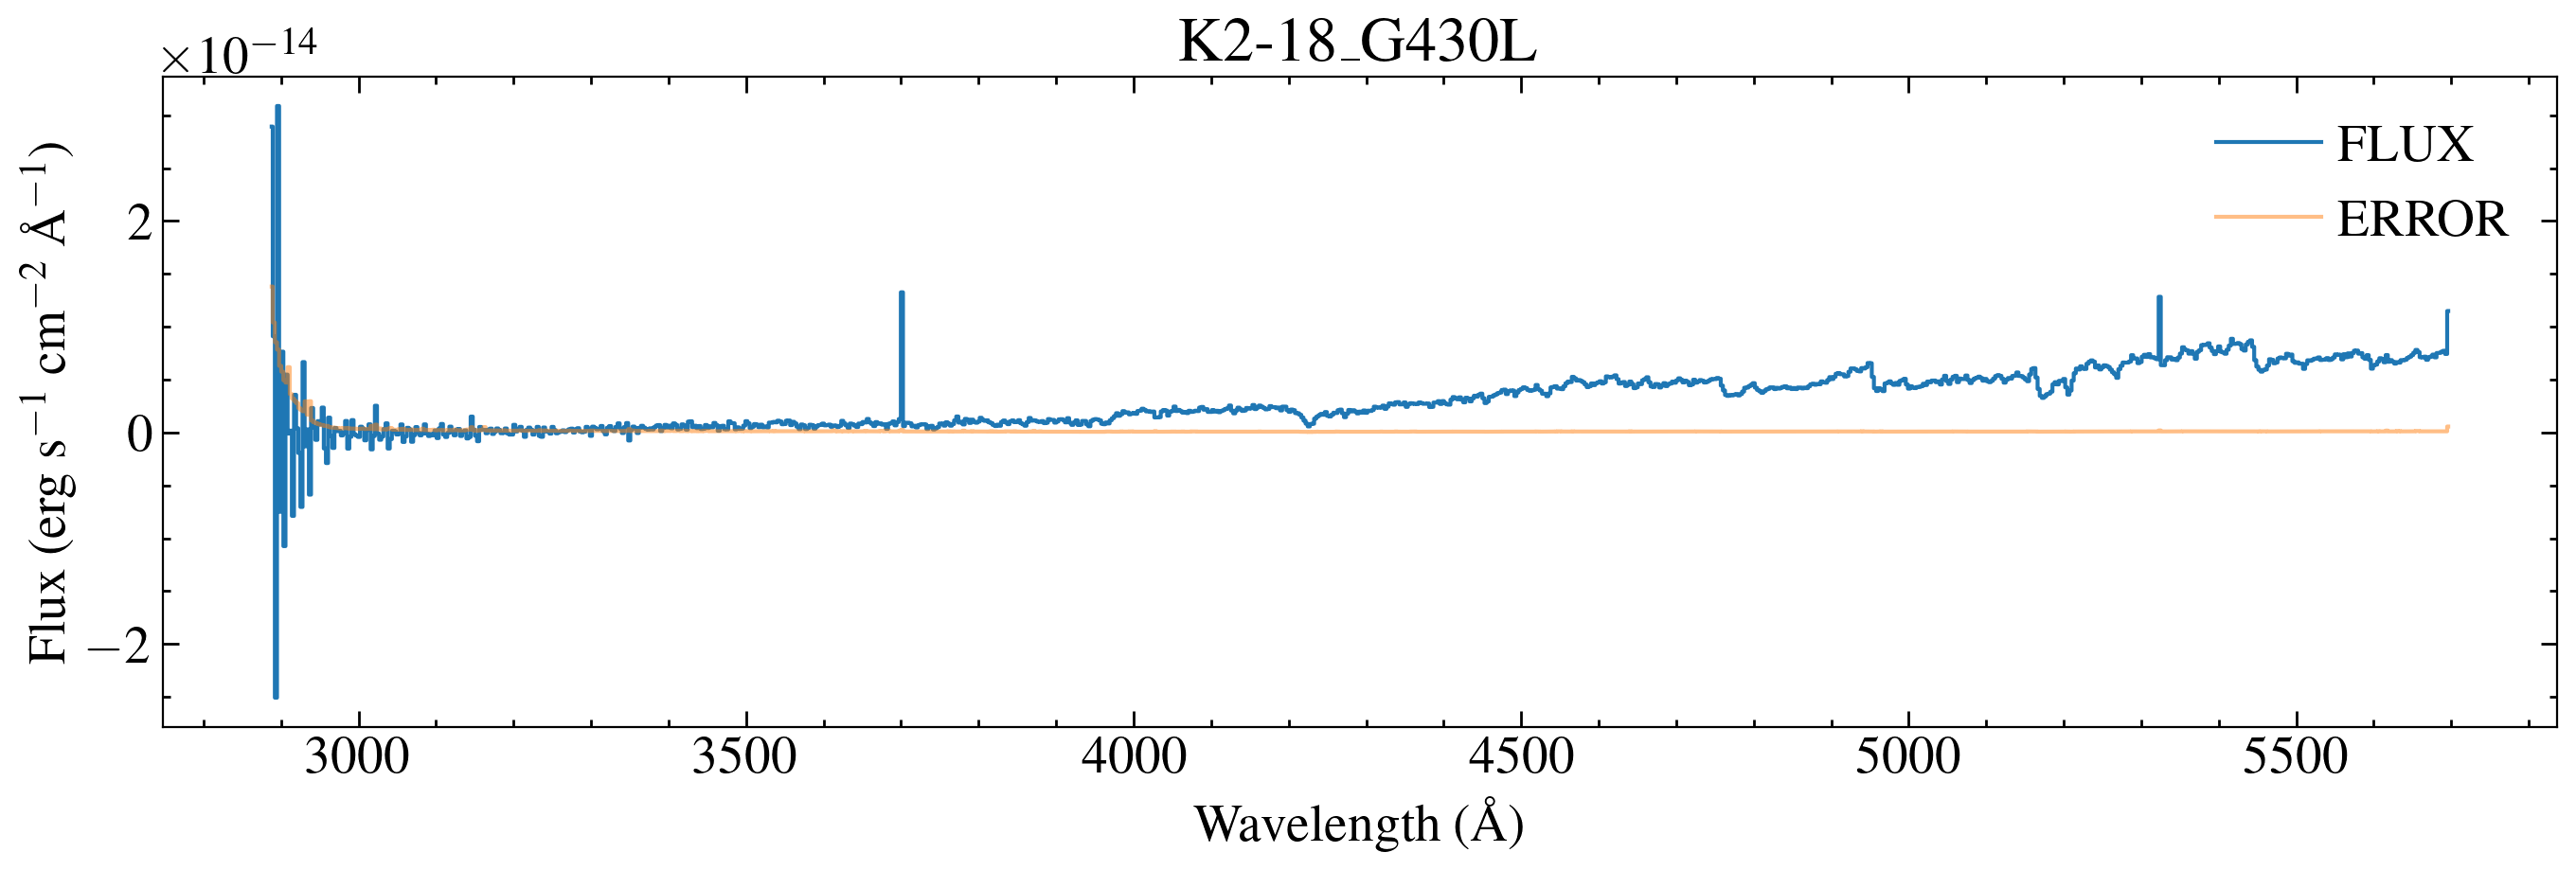

Spectrum saved as hlsp_muscles_hst_stis_k2-18_g430l_v1_component-spec.fits


In [23]:
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/use_spectra/'
savepath = 'draft_hlsp/k2-18/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'K2-18')

Pause while I redo the HSLP headers. Made the HASP products as well, let's have a look

4.8370170230221525


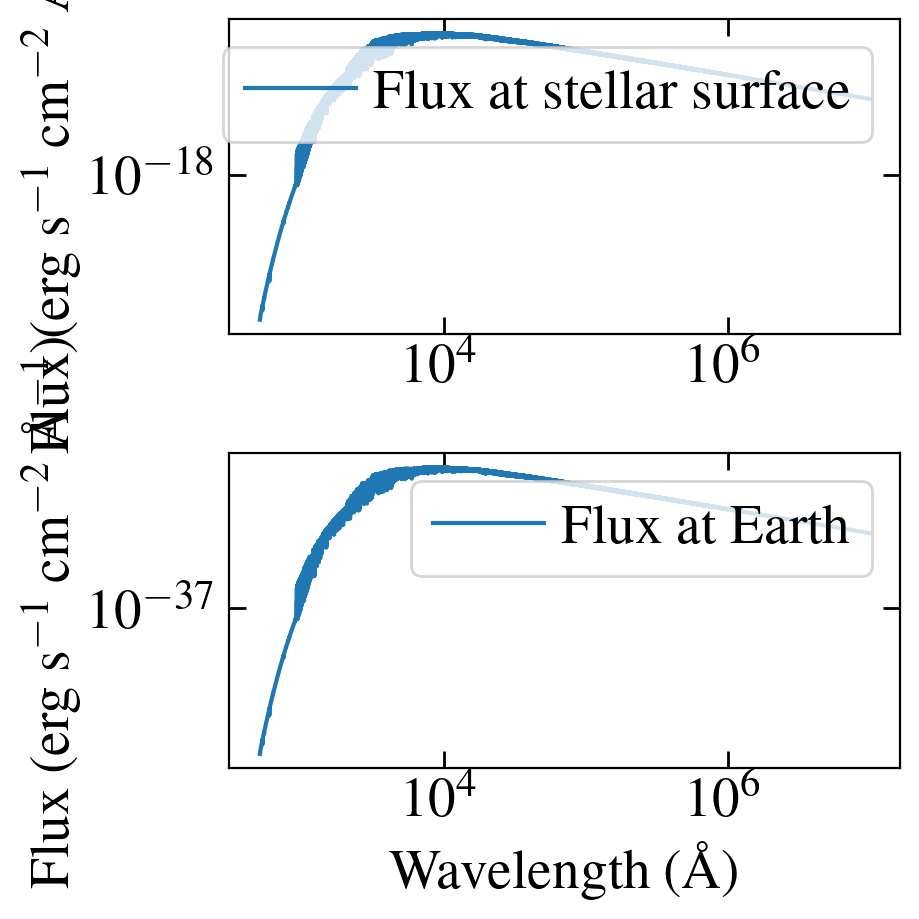

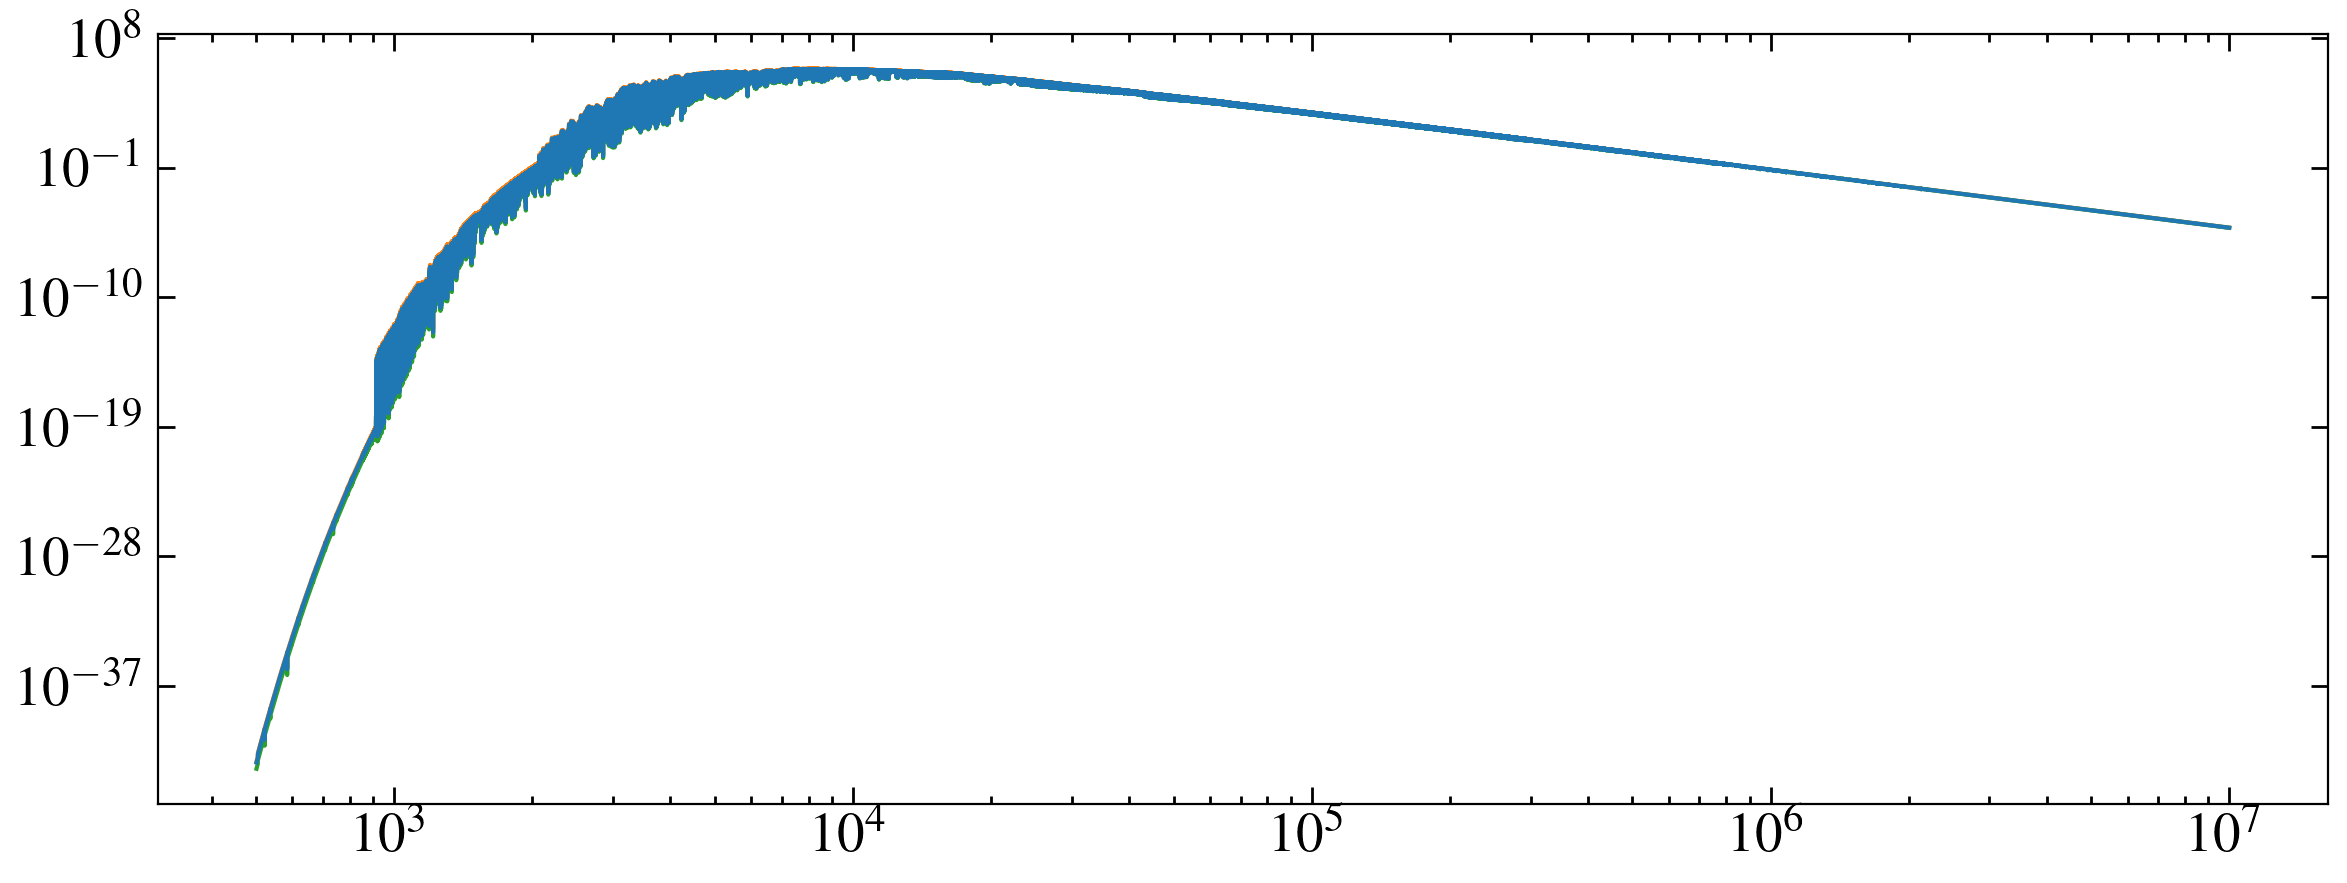

In [35]:
import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.4951 
teff = 3457
teff_e = 39

radius = 0.4445
distance = 38.025

save_path = 'models/'
star = 'K2-18'
g = np.log10((((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)).value)
print(g)
# g = 4.77
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [29]:
hlsp_x1ds = glob.glob('draft_hlsp/k2-18/*hst*.fits')
hlsp_x1ds

['draft_hlsp/k2-18/hlsp_muscles_hst_stis_k2-18_g230l_v1_component-spec.fits',
 'draft_hlsp/k2-18/hlsp_muscles_hst_stis_k2-18_g430l_v1_component-spec.fits']

In [146]:
phot = Table.read('misc_data/k2-18_phot.vot')
print(phot.dtype.names)




('_RAJ2000', '_DEJ2000', '_tabname', '_ID', '_tab1_31', '_tab1_32', 'sed_freq', 'sed_flux', 'sed_eflux', 'sed_filter')


--
--
--
--
--
--
0.038
0.012
0.0025
...
1e-05


(3000.0, 4000.0)

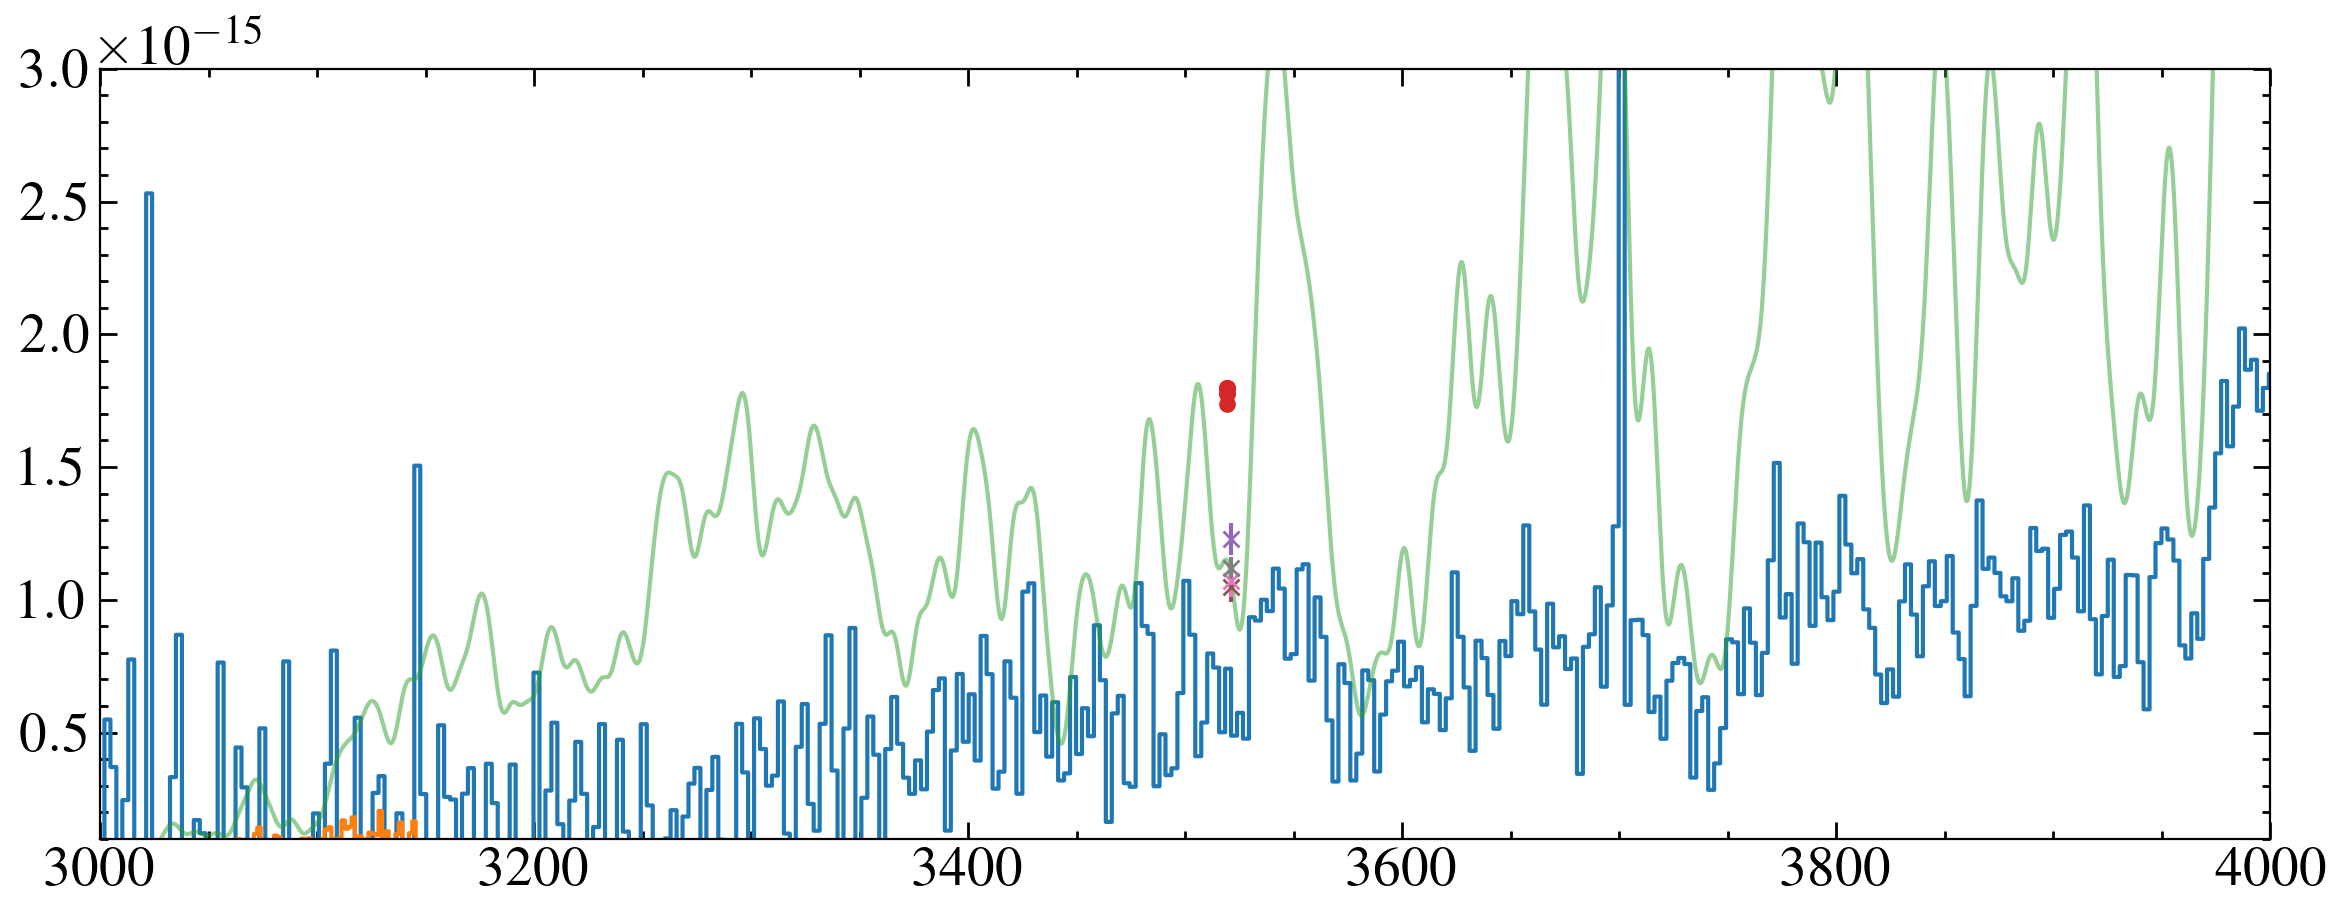

In [160]:
for x in hlsp_x1ds[::-1]:
    # print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 4000)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 300000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,1000)
plt.plot(pwi, pfi, alpha=0.5)
    



mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 



phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w))
phot_e =np.array(phot['sed_eflux'][mask])
phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f.value

mask = phot_f.value/phot_e > 10
# print(phot_e)
# print(phot_e)
plt.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5)

# plt.scatter(3520, 1.74e-15) #sdss, hints that the data is wrong..
# plt.scatter(4820, 1.1e-14) 
sUw = 3520.88 # swift Uband effective wavelength
sUf = [1.23e-15, 1.05e-15, 1.07e-15, 1.12e-15]
sUe = [0.06e-15, 0.06e-15, 0.06e-15, 0.04e-15]

for U, Ue in zip(sUf, sUe):
    plt.errorbar(sUw, U, yerr=Ue, marker='x')

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-18, 1e-13)
# plt.xlim(2000, 2e5)
plt.ylim(1e-16, 3e-15)
plt.xlim(3000, 4000)

PHX not great there, check with Gaia spectrum? Doesn't have one. Checked against all photometry. Darn, looks like it might be the spectrum.

In [119]:
spath = '/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/'
images = glob.glob('{}*/uvot/products/*sk.img.gz'.format(spath))
for i in images:
    print(i)
    hdul = fits.open(i)
    # print(hdul.info())
    # print(len(hdul))
    if len(hdul) > 1:
        hdr = hdul[1].header
        print(hdr['FILTER'])
# lots of u band

/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843001/uvot/products/sw00012843001u_sk.img.gz
U
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843002/uvot/products/sw00012843002u_sk.img.gz
UVW2
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843003/uvot/products/sw00012843003u_sk.img.gz
U
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843004/uvot/products/sw00012843004u_sk.img.gz
UVW2
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843006/uvot/products/sw00012843006u_sk.img.gz
UVW2
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843007/uvot/products/sw00012843007u_sk.img.gz
U
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843008/uvot/products/sw00012843008u_sk.img.gz
UVW2
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843009/uvot/products/sw00012843009u_sk.img.gz
U
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843010/uvot/products/sw00012843010u_sk.img.gz
UVW2
/media/david/2tb_ext_hd/hddata/meats/swift/k2-18/00012843011/uvot/p

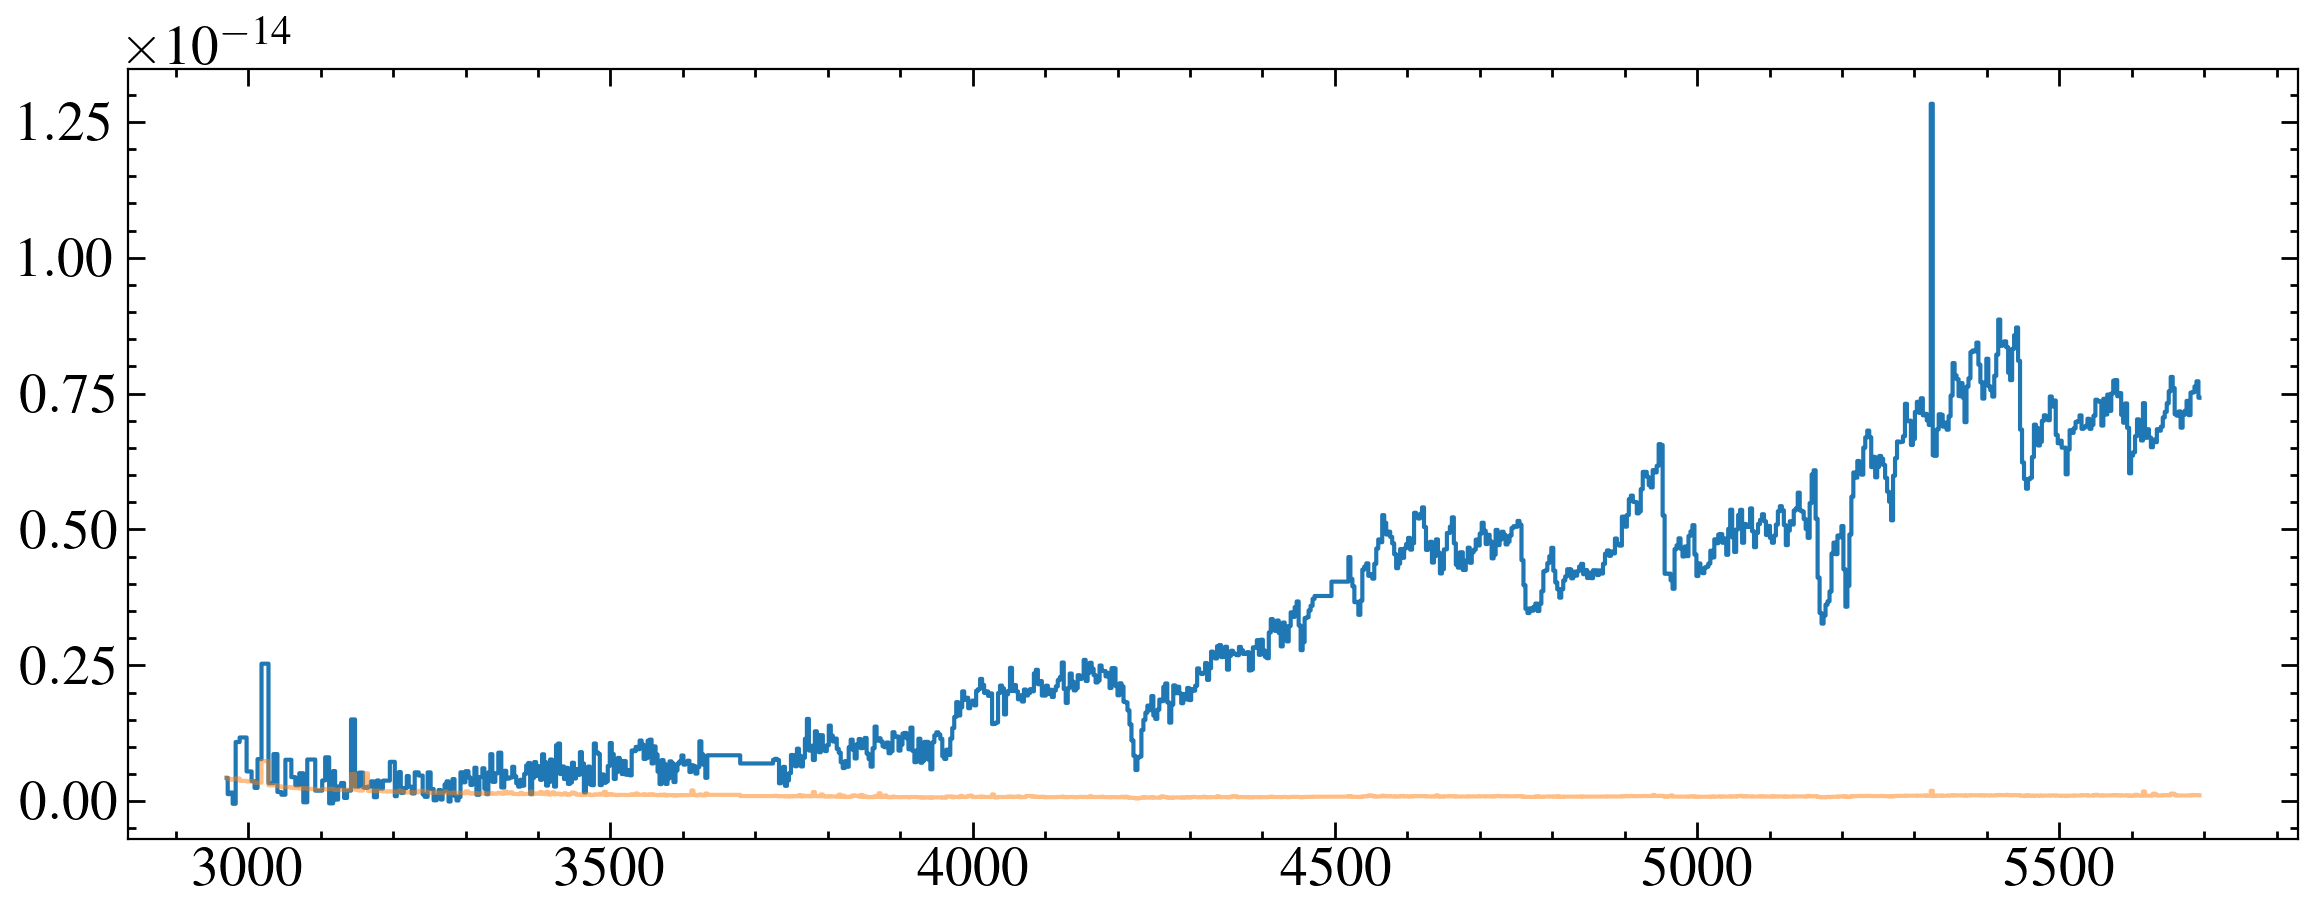

In [168]:
for x in hlsp_x1ds:
    # print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        # mask = (w > 3000) & (w < 5520) & (dq < 17)
        mask = dq < 17
    
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid')
        plt.step(w, e, where='mid', alpha=0.5)
        # plt.step(w, dq, where='mid')
        # plt.yscale('log')

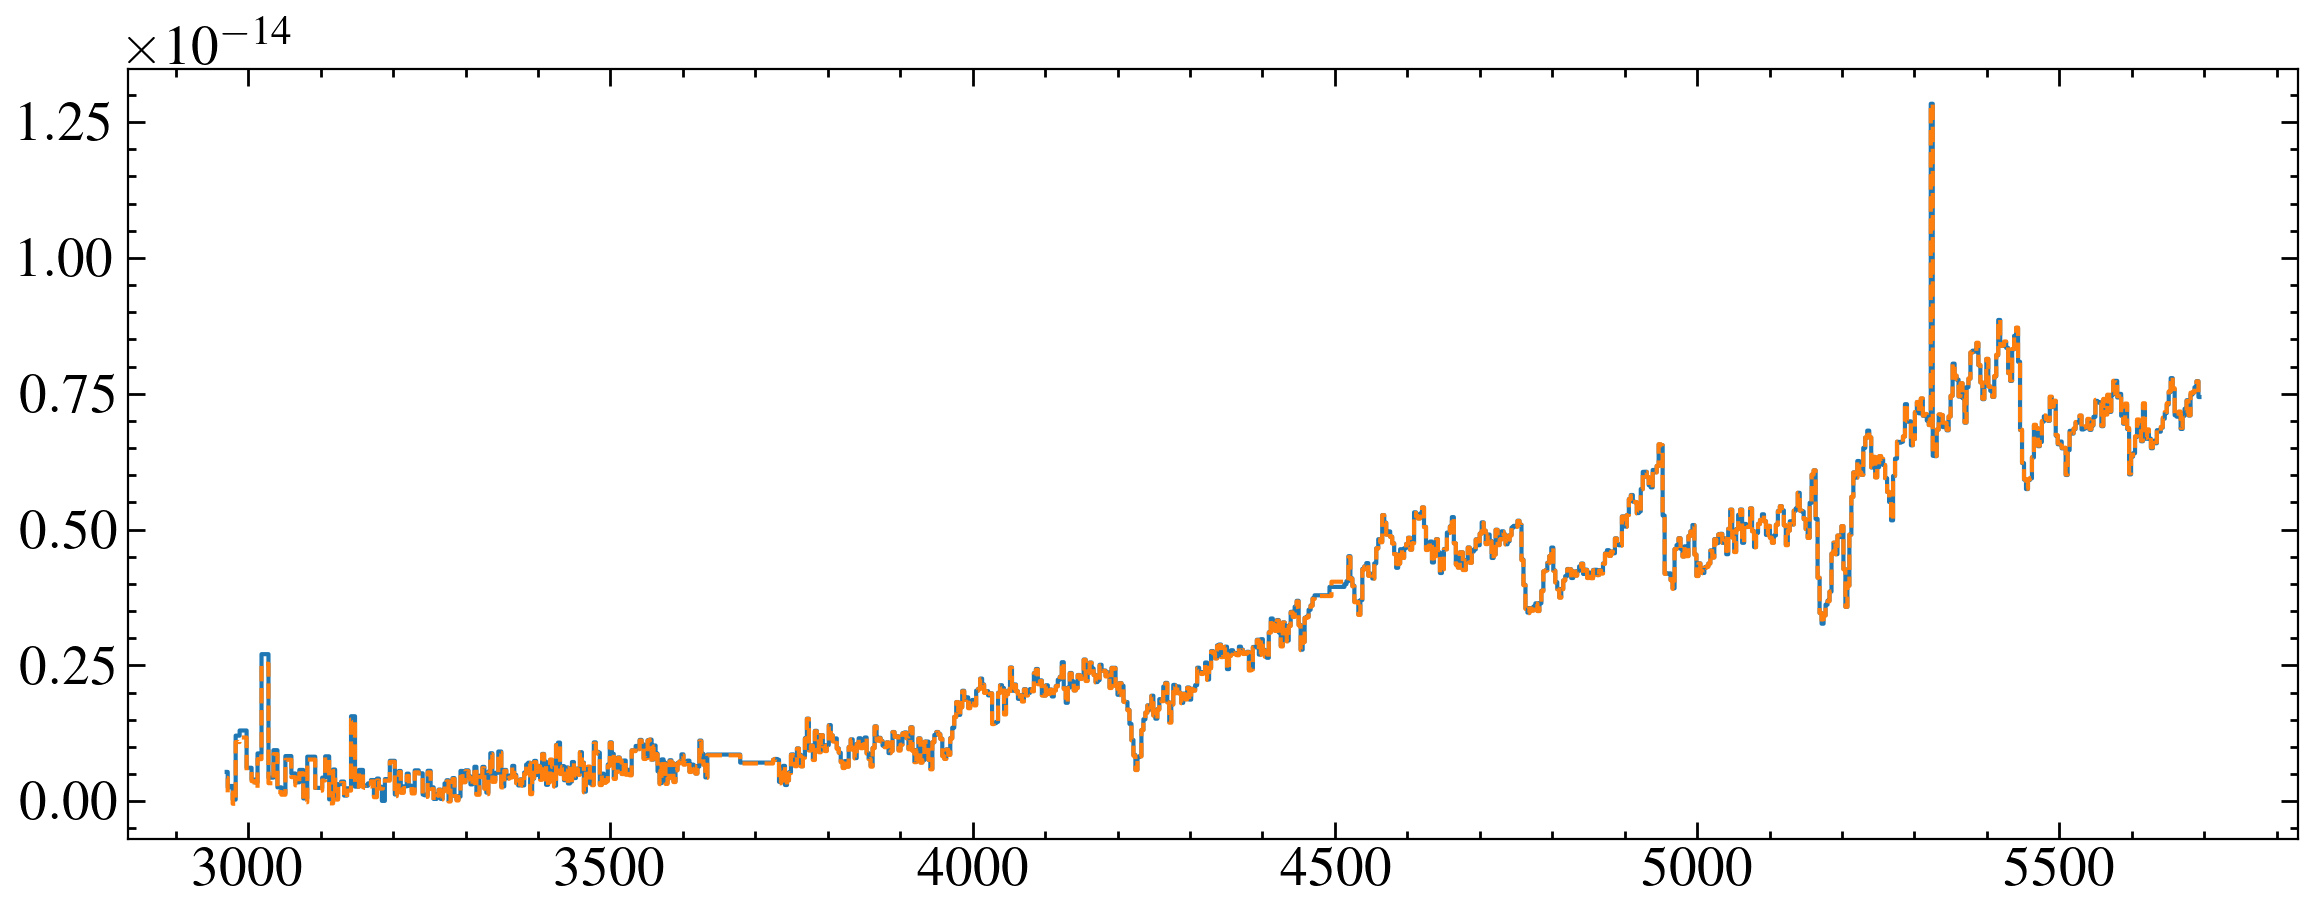

In [182]:
root = 'oeoo18050' 
flt = '{}/{}_crj.fits'.format(path, root)
   
rootname = fits.getheader(flt)['ROOTNAME'] 
outname = 'reextractions/k2-18/{}_new_sx1.fits'.format(rootname)
if os.path.exists(outname):
    os.remove(outname)

offset = 30
size = 5
stistools.x1d.x1d(flt, output = outname, trailer='reextractions/k2-18/{}_new.trl'.format(rootname), a2center=891, 
                  maxsrch=5, bk1offst=offset, bk2offst=offset, bk1size=size, bk2size=size)

data = fits.getdata(outname, 1)[0]
plt.step(data['WAVELENGTH'][data['DQ'] < 17], data['FLUX'][data['DQ'] < 17], where='mid')
plt.step(w, f, where='mid', ls='--')


Ok extraction is good. Blerugh. Compare with proxy GJ 832.

In [183]:
proxypath = '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj832/hlsp_muscles_multi_multi_gj832_broadband_v22_var-res-sed.fits'
prox = fits.getdata(proxypath, 1)
proxw, proxf, proxe = prox['WAVELENGTH'], prox['FLUX'], prox['ERROR']

(3000.0, 6000.0)

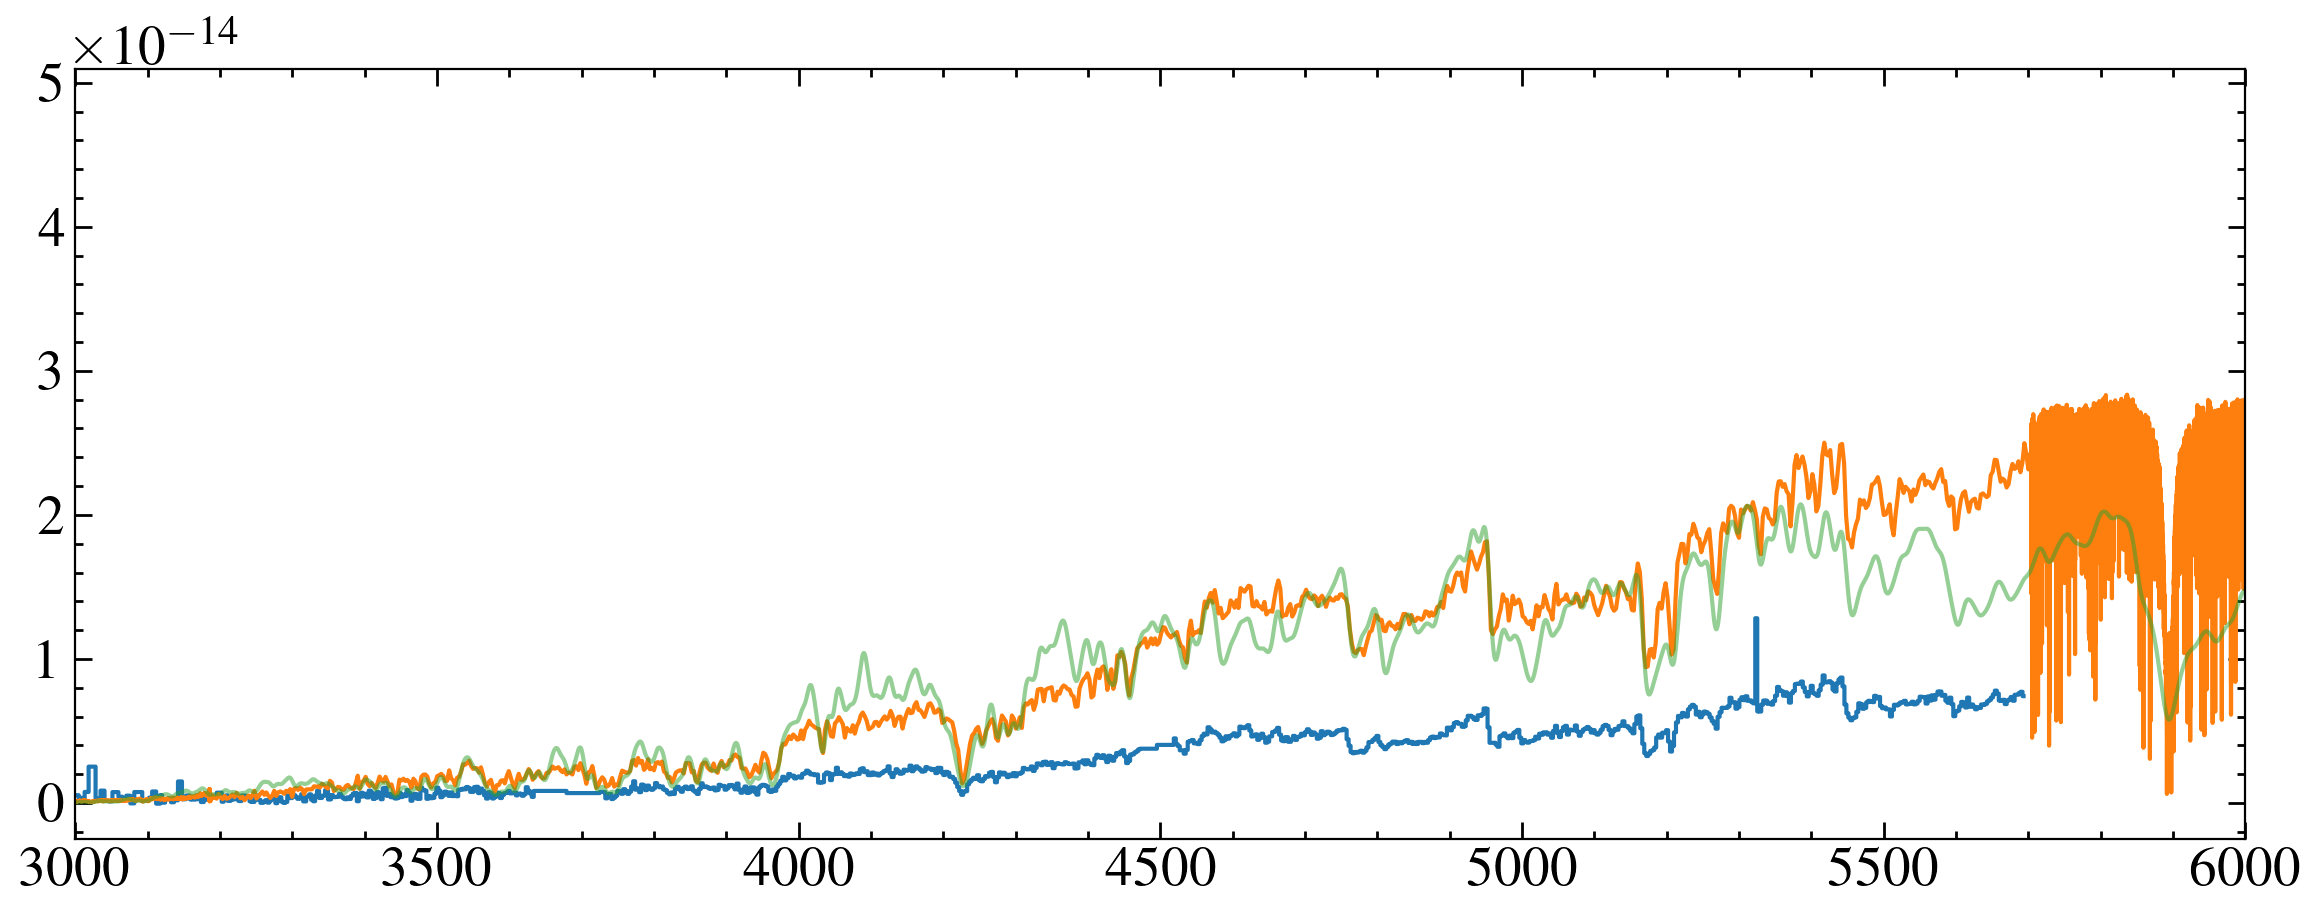

In [193]:
# plt.plot(proxw, proxf)
# plt.yscale('log')
# plt.xscale('log')

proxdist = 1000/201.3252

scale = (proxdist/distance)**2

plt.step(w, f, where='mid')
plt.plot(proxw, proxf*scale)
plt.plot(pwi, pfi, alpha=0.5)

plt.xlim(3000, 6000)


Well something's up.

In [200]:
jits = glob.glob('{}oeoo*jit.fits'.format(path))
jits

['/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18040_jit.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18020_jit.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18030_jit.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo18050_jit.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/k2-18/oeoo38010_jit.fits']

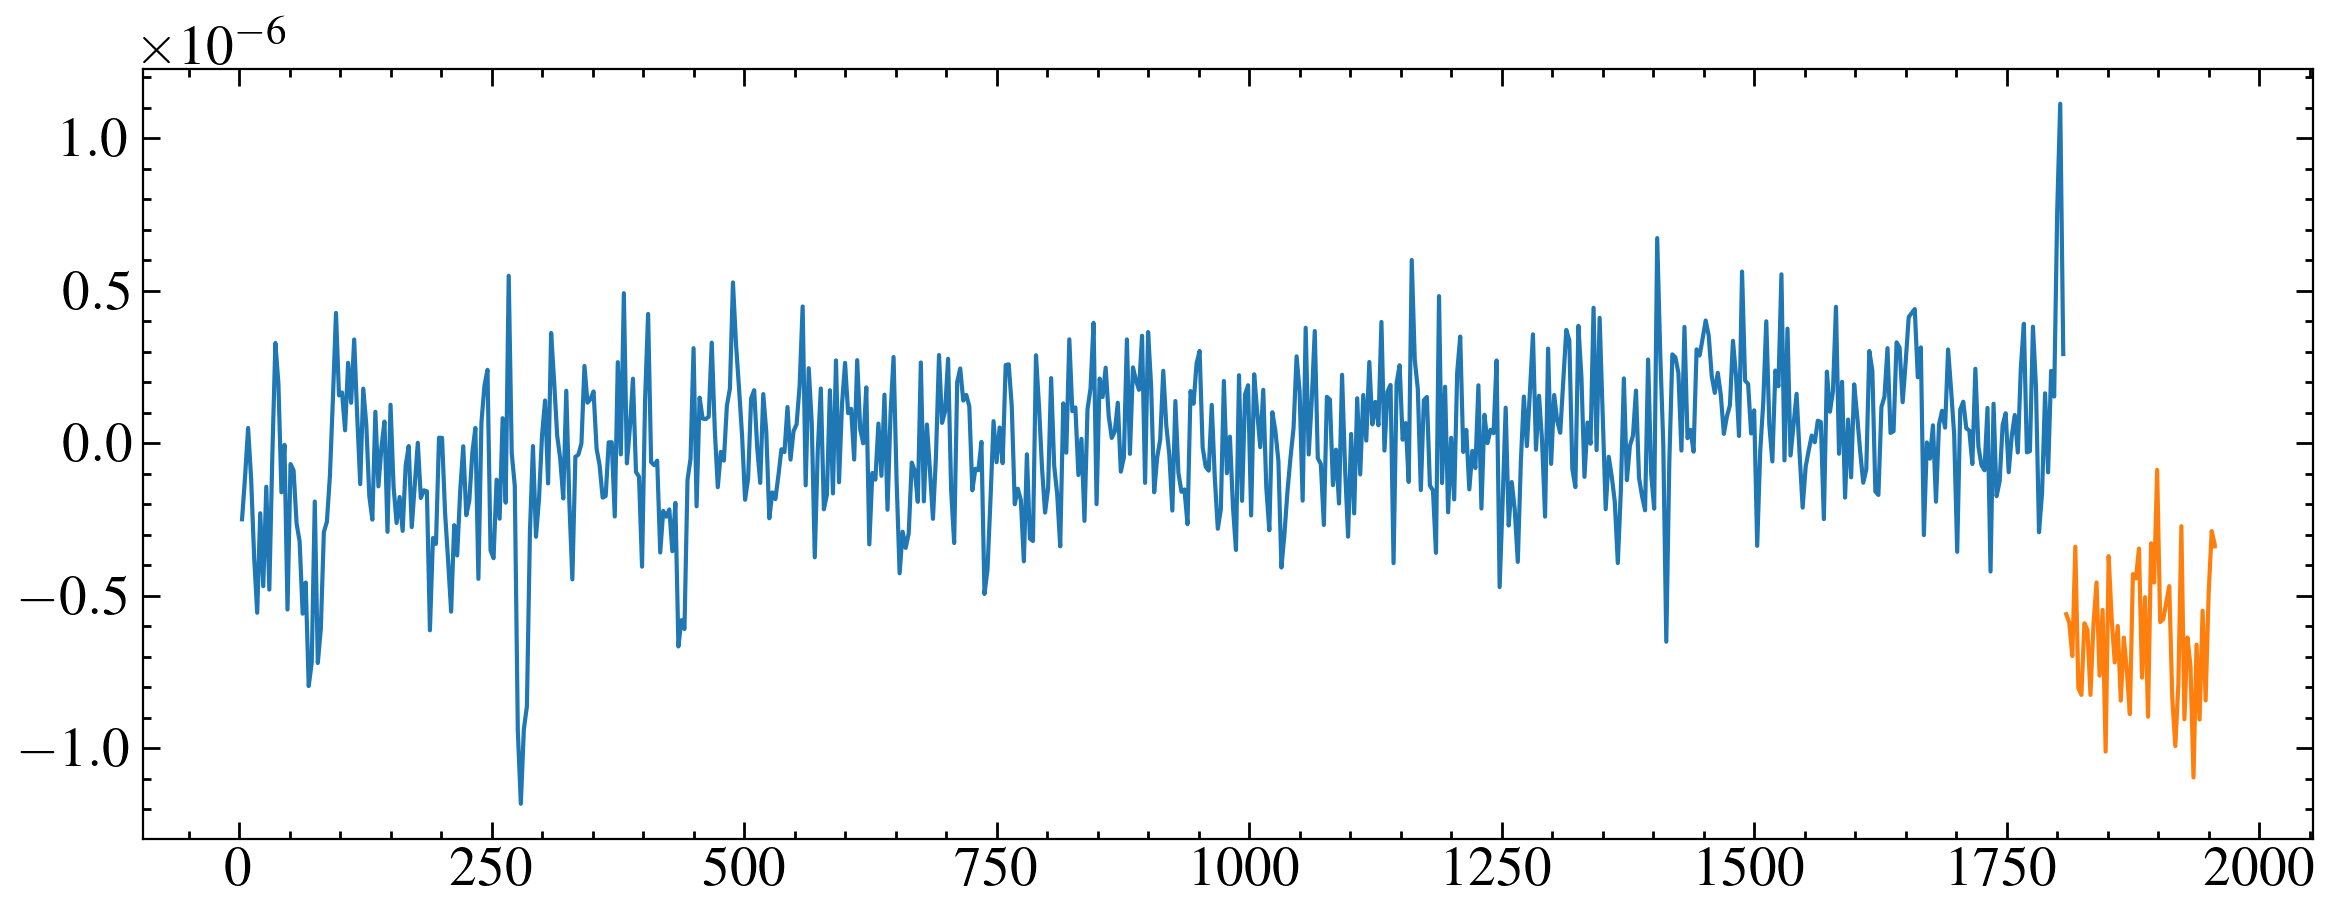

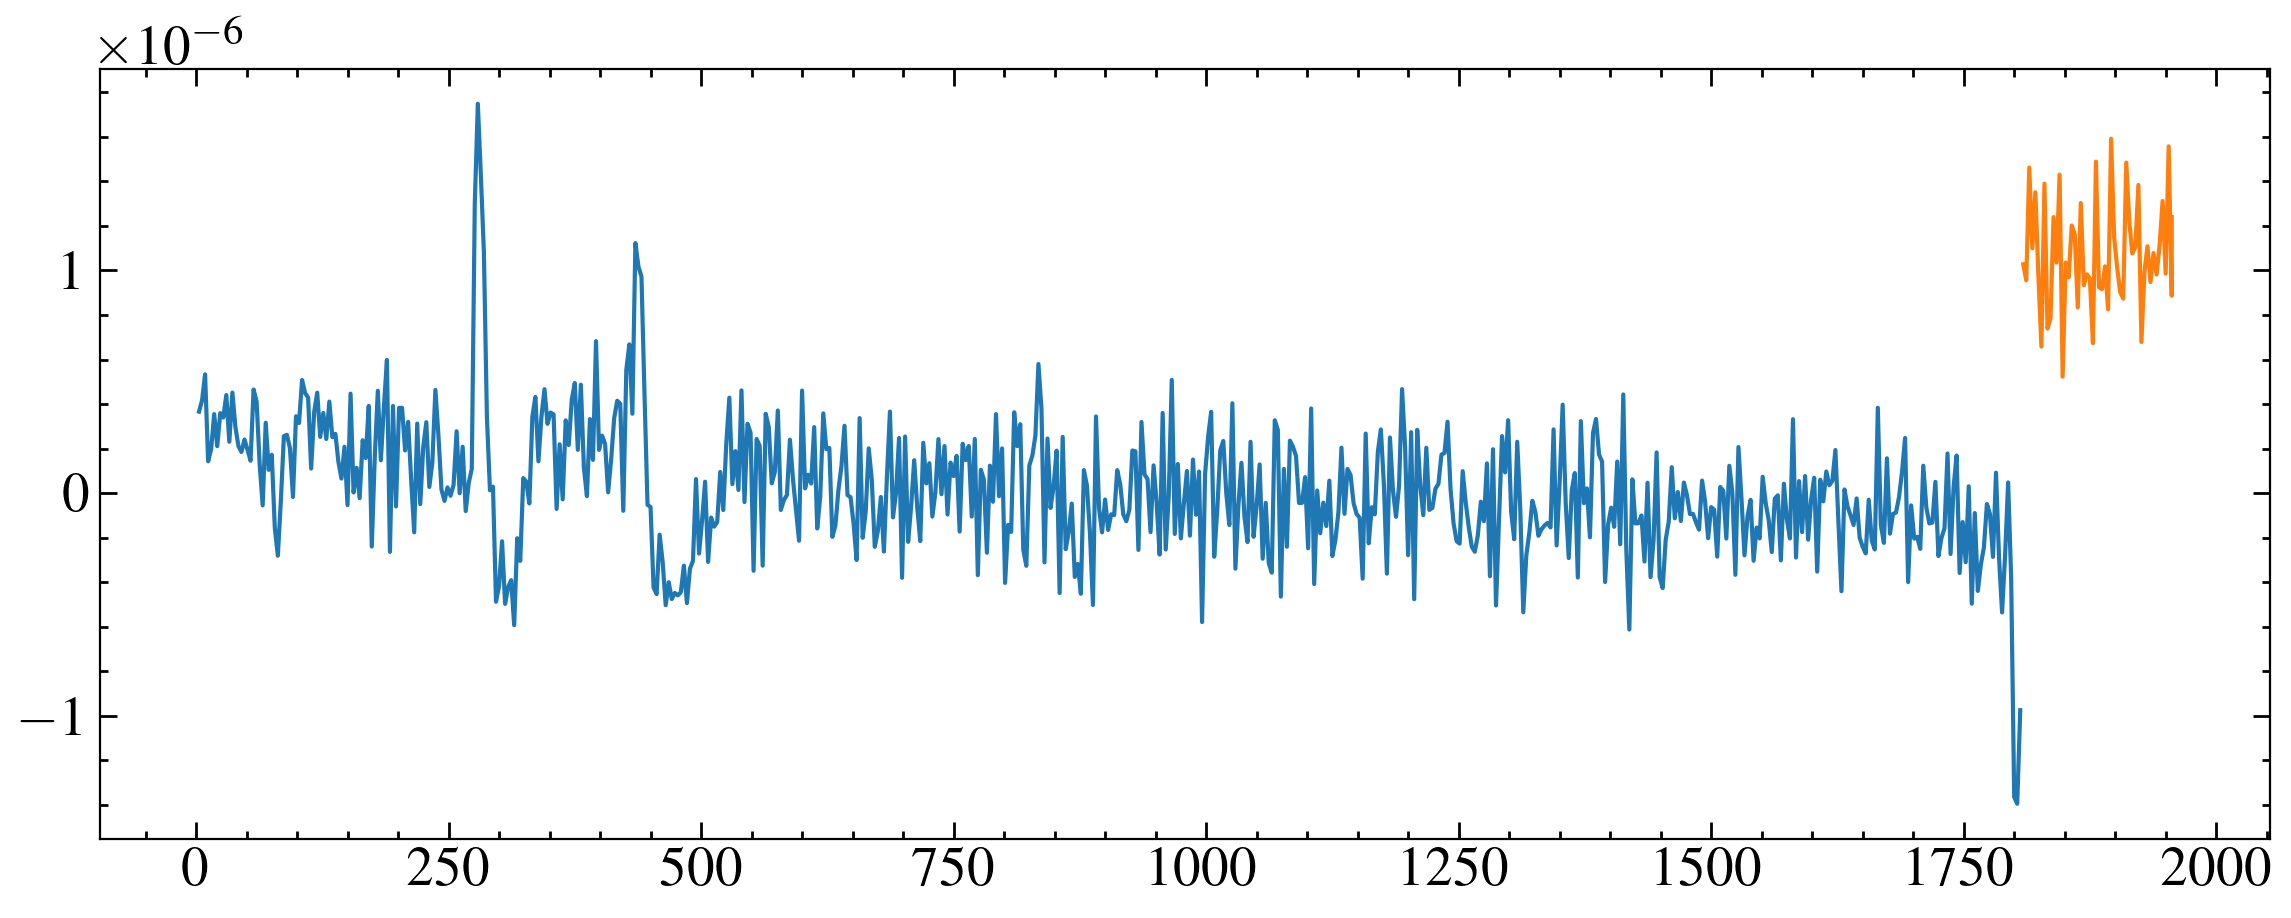

In [218]:

data1= fits.getdata(jits[0], 1)
t1, ra1, dec1 = data1['SECONDS'], data1['RA'], data1['DEC']
data2= fits.getdata(jits[3], 1)
t2, ra2, dec2 = data2['SECONDS'], data2['RA'], data2['DEC']

plt.plot(t1, ra1-np.median(ra1))
plt.plot(t2+t1[-1], ra2-np.median(ra1))
plt.show()

plt.plot(t1, dec1-np.median(dec1))
plt.plot(t2+t1[-1], dec2-np.median(dec1))
plt.show()


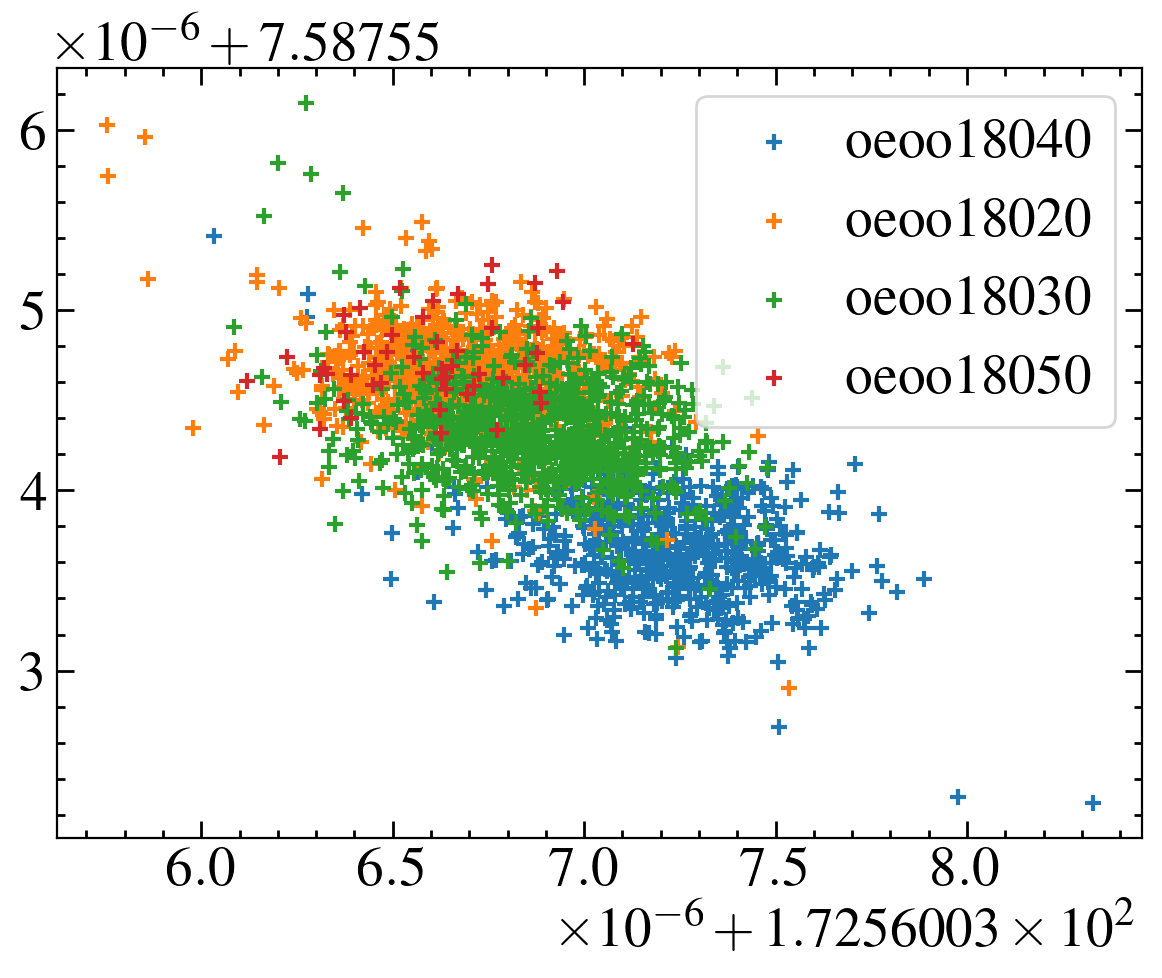

In [229]:
fig, ax = plt.subplots(figsize=(7,5))
ra= 1.725599762993E+02
dec = 7.587575245737E+00
for jit in jits[:-1]:
    hdr = fits.getheader(jit, 0)
    data = fits.getdata(jit)
    ax.scatter(data['RA'], data['DEC'], marker='+', label = hdr['ROOTNAME'])
    ax.legend(frameon=True)
# ax.scatter(ra, dec)

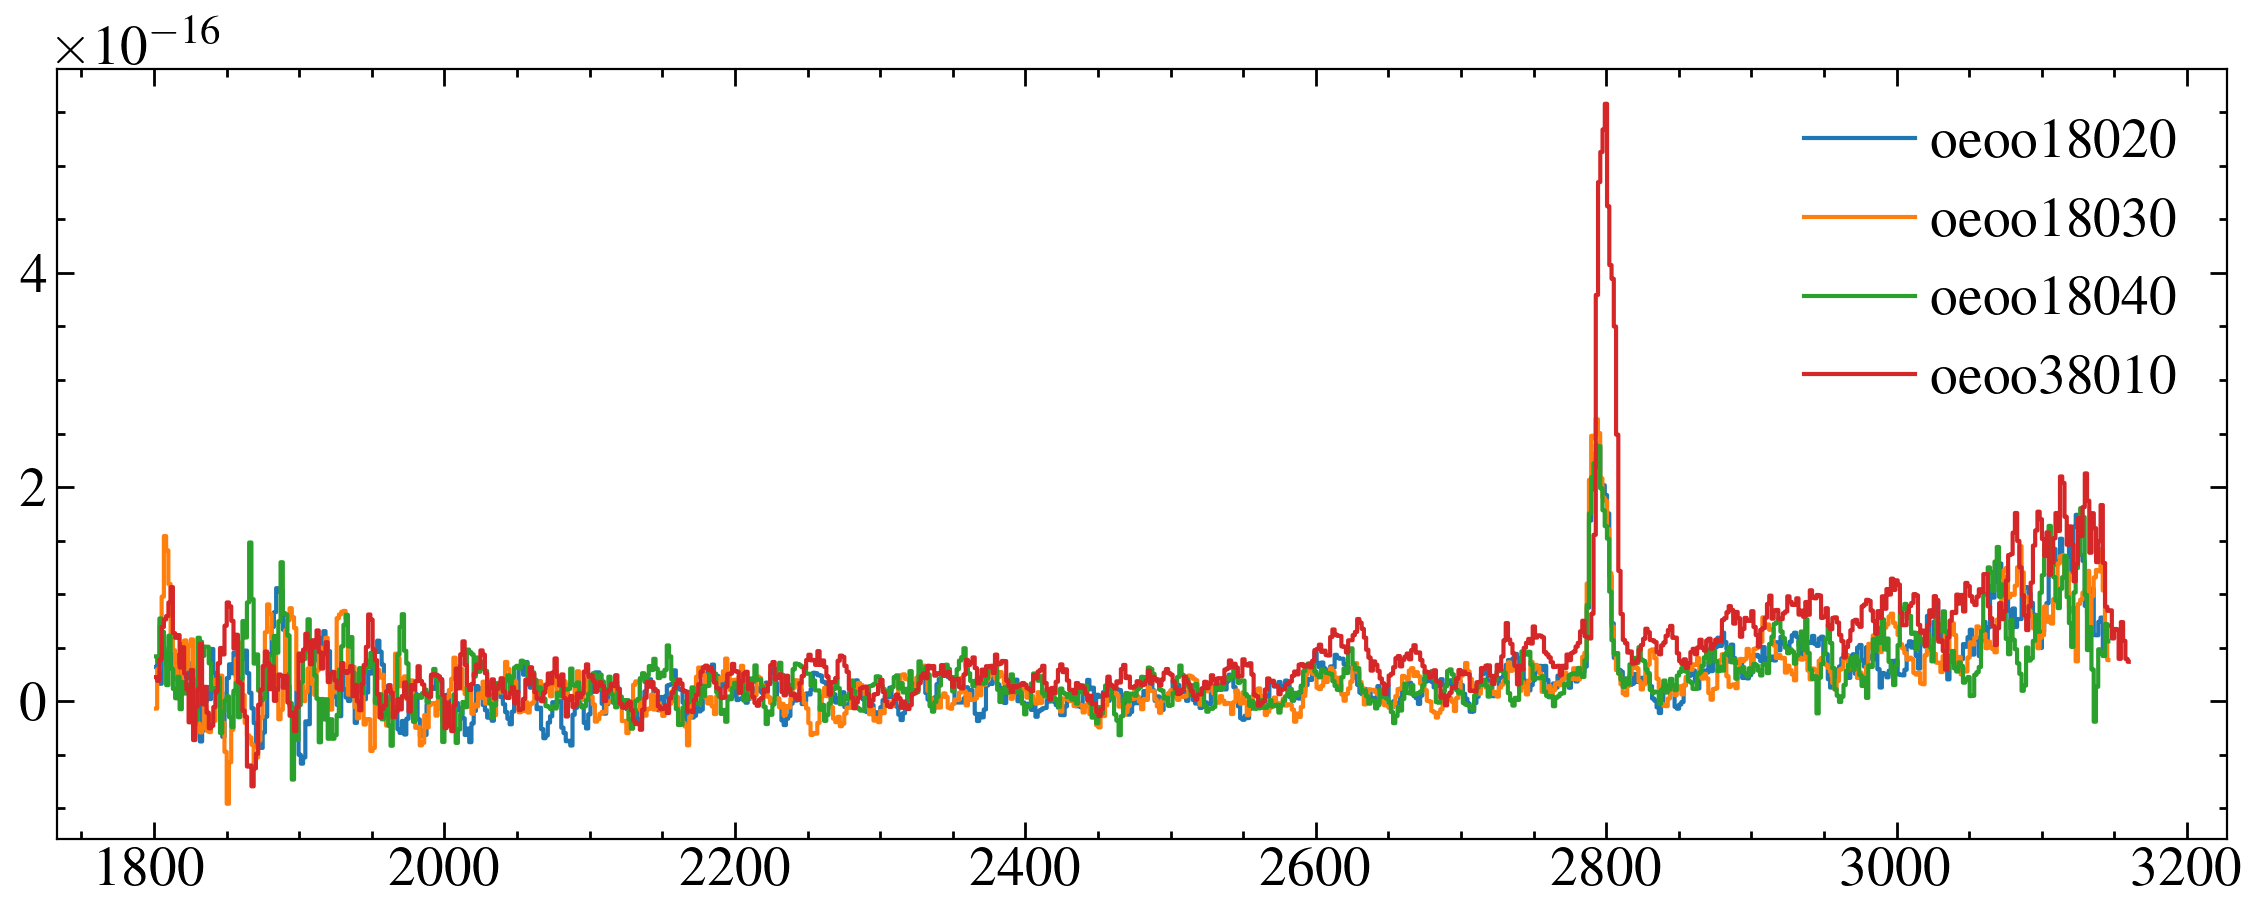

In [242]:
for x in glob.glob('{}*x1d.fits'.format(x1dpath)):
    if fits.getheader(x, 0)['OPT_ELEM'] == 'G230L':
        hdr = fits.getheader(x, 0)

        data = fits.getdata(x, 1)[0]
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = w > 1800
        w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f, Box1DKernel(5))
        plt.step(w, f, where='mid', label=hdr['ROOTNAME'])
        # plt.step(w, e, where='mid')
plt.legend()

Arrrrrghhghghfhhfhfhfhfh